In [ ]:
#pip install --upgrade matplotlib  # to ensure we run with 3.6.3 instead of 3.2.2

In [ ]:
pip install -U kaleido

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import OrderedDict
from scipy.stats import spearmanr
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from scipy.optimize import nnls
from scipy.stats import t
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model as lm
from sklearn.decomposition import PCA
from geopy.geocoders import Nominatim
from collections import Counter
from textwrap import wrap
import folium
import io
import sys
import ssl

pd.options.mode.chained_assignment = None

In [ ]:
drive.mount('/content/drive')

In [ ]:
path= "/content/drive/MyDrive/Colab Notebooks/votes per ballot 2022.csv"
df_ballots_2022_raw = pd.read_csv(path, encoding = 'utf8', index_col='ברזל')
df_ballots_2022 = df_ballots_2022_raw[df_ballots_2022_raw['שם ישוב']!='מעטפות חיצוניות']  # removing "metadata" columns


path= "/content/drive/MyDrive/Colab Notebooks/votes per ballot 2021.csv"
df_ballots_2021_raw = pd.read_csv(path, encoding = 'iso-8859-8', index_col='ברזל')
df_ballots_2021 = df_ballots_2021_raw[df_ballots_2021_raw['שם ישוב']!='מעטפות חיצוניות']  # removing "metadata" columns
df_ballots_2021 = df_ballots_2021.loc[:,df_ballots_2021.columns[:-1]]

path= "/content/drive/MyDrive/Colab Notebooks/votes per ballot 2020.csv"
df_ballots_2020_raw = pd.read_csv(path, encoding = 'iso-8859-8', index_col='ברזל')
df_ballots_2020 = df_ballots_2020_raw[df_ballots_2020_raw['שם ישוב']!='מעטפות חיצוניות']  # removing "metadata" columns
df_ballots_2020 = df_ballots_2020.loc[:,df_ballots_2020.columns[:-1]]

path= "/content/drive/MyDrive/Colab Notebooks/bycode2021.csv"
bycode2021 = pd.read_csv(path, encoding = 'utf8')

path= "/content/drive/MyDrive/Colab Notebooks/eshkol_hevrati_calcali.csv"
eshkol_hevrati_calcali_df = pd.read_csv(path, encoding = 'utf8')


# letters to parties name dictionary 
parties_letters_to_name_dict_2022 ={"אמת":"עבודה", "ב":"הבית היהודי", "ג":"יהדות התורה","ום":"חדש-תעל","ט":"הציונות הדתית","כן":"המחנה הממלכתי"
,"ל":"ישראל ביתנו","מחל":"ליכוד","מרצ":"מרצ","עם":"רע'מ","פה":"יש עתיד","שס":"שס","ד":"בלד"
,"אצ":"חופש כלכלי","ז":"שחר כוח חברתי","זך":"קמה","זנ":"כח להשפיע","זץ":"צומת","י":"ישראל חופשית דמוקרטית",
"יז":"הכלכלית החדשה","ינ":"איחוד בני הברית","יץ":"צו השעה","יק":"מפלגת הגוש התנכי","ך":"אני ואתה","נז":"כבוד האדם",
"ני":"נתיב","נף":"מפלגת שמע","נץ":"העצמאים החדשים","נק":"יש כיוון","נר":"אנחנו","ף":"הפיראטים","צ":"צעירים בוערים",
"ץ":"מנהיגות חברתית","ק":"קול הסביבה והחי","קי":"הלב היהודי","קך":"סדר חדש","קנ":"כל קול קובע","קץ":"באומץ בשבילך",
"רז":"רשימת שלושים\ארבעים","ת":"דעת טוב ורע, עלה ירוק","לא הצביעו":"לא הצביעו"}


# letters to parties name dictionary 
parties_letters_to_name_dict_2021 ={"אמת":"עבודה", "ב":"ימינה", "ג":"יהדות התורה","ט":"הציונות הדתית","כן":"כחול לבן "
,"ל":"ישראל ביתנו","מחל":"ליכוד","מרצ":"מרצ","עם":"רע'מ","פה":"יש עתיד","ודעם":"המשותפת","שס":"שס","י":"מפץ חברתי",
"ת":"תקווה חדשה","יז":"הכלכלית החדשה","ר":"רפא","ףז":"הפיראטים","כך":"אני ואתה","רנ":"התקווה לשינוי","קץ":"משפט צדק",
"זץ":"צומת","רף":"מפלגת עם שלם","קך":"סדר חדש","נ":"קמ׳ה","ק":"הבלתי אפשרי, אפשרי","כ":"הלב היהודי","צי":"עצמנו",
"יק":"הגוש התנכי","ני":"עולם חדש","ינ":"ברית השותפות","ז":"הישראלים","קי":"שמע","ץ":"דעם","יר":"מנהיגות חברתית",
"צכ":"מען","צף":"חץ","נר":"אנחנו","יף":"כבוד האדם","רק":"דמוקרטית","לא הצביעו":"לא הצביעו"}

# calculate additional voters by kosher votes distribution
def create_df_with_additional_votes(df):
  bzb = df['בזב']
  df = df.iloc[:,2:].div( df["כשרים"], axis=0) # calculate kosher votes distribution
  df = df.mul(bzb,axis=0) #multiply by בזב in order to get votes if everyone would vote
  return df

ballot_correction_2022_df = create_df_with_additional_votes(df_ballots_2022[['בזב']+list(df_ballots_2022.columns[9:])])
ballot_correction_2022_df['בזב'] = df_ballots_2022['בזב']

# calculate the p based on if everyone would vote
def calculate_p_if_all_vots(add_df,org_df):
  vots_if_all_df = pd.DataFrame(add_df[add_df.columns[:-1]].sum()/add_df.loc[:,"בזב"].sum(),
                                columns =["corrected P"])
  vots_if_all_df["original P"] = org_df[org_df.columns[4:]].sum()/org_df.loc[:,"כשרים"].sum()
  vots_if_all_df = vots_if_all_df.rename(index=parties_letters_to_name_dict_2022)
  vots_if_all_df.index.names = ['party']
  return vots_if_all_df

# Function for converting votes to seats (code by Micha Hashkes)
def calc_mand(votes_df, hasima=0.0325, show_calc=False):
    """
    Function to calculate the mandates for each party using the Bader-Ofer formula
    Parama: 
        votes_df: the df of all the votes for all the parties. the df has 4 columns- [party_name,Valid_votes,Inalid_votes,Double_envelopes]
        hasima: hasima percentage (a number between 0-1).
        show_calc: if the user wants to see the df at each iteration  
    return: df with mandates for each party after using the Bader-Ofer formula 
    """
    votes_df = votes_df.copy() # create a copy of the votes df
    # create columns that sum all the valid votes for each party
    votes_df["s_valid_votes"]=votes_df["Valid_votes"] +votes_df["Double_envelopes"]
    # create df with the parties that pass the hasima percentage
    p_hasima_df = votes_df[(votes_df["s_valid_votes"])/(votes_df["s_valid_votes"].sum())>hasima]
    # calculate the floored current mandates for all the parties that pass the hasima percentage
    p_hasima_df = p_hasima_df.assign(curr_mand =np.floor(120*p_hasima_df["s_valid_votes"]/p_hasima_df["s_valid_votes"].sum()))
    #calc the b_o - Bader-Ofer furmula
    p_hasima_df = p_hasima_df.assign(curr_b_o = p_hasima_df["s_valid_votes"]/(((p_hasima_df["curr_mand"]+1)*p_hasima_df["s_valid_votes"].sum()/120)))
    # loop for the rest of the mandates and every time add to the highest curr_b_o +1 to the mandates
    for i in range(0,int(120-p_hasima_df["curr_mand"].sum())): 
        if show_calc: # in case the user wants to see the steps, print them
            print(i)
            print(p_hasima_df[["party_n","s_valid_votes","curr_mand","curr_b_o"]])
        p_hasima_df.at[p_hasima_df[['curr_b_o']].idxmax()[0], 'curr_mand']+=1
        p_hasima_df = p_hasima_df.assign(curr_b_o = p_hasima_df["s_valid_votes"]/((p_hasima_df["curr_mand"]+1)*(p_hasima_df["s_valid_votes"].sum()/120)))
        #p_hasima_df =p_hasima_df.set_index('index')
        #print(p_hasima_df.columns)
    return p_hasima_df[["party_n","s_valid_votes","curr_mand"]]

def df_valid_for_calc_mandat(df):
  sums_df = pd.DataFrame((df.sum(axis=0)).T)
  sums_df.index.names = ['index']
  sums_df['Inalid_votes'] = 0
  sums_df['Double_envelopes'] = 0
  sums_df.columns = ['Valid_votes','Inalid_votes','Double_envelopes']
  sums_df['party_n'] = sums_df.index
  sums_df = sums_df.reset_index()
  return sums_df

ballot_vots_if_all_df = calculate_p_if_all_vots(ballot_correction_2022_df,df_ballots_2022) 
ballot_vots_if_all_df = ballot_vots_if_all_df.sort_values(by='original P',ascending=False).iloc[0:13,:] #top 13 parties

voting_rate = df_ballots_2022['כשרים'].sum()/df_ballots_2022['בזב'].sum()
voting_rate_raam = df_ballots_2022['עם'].sum()/ballot_correction_2022_df['עם'].sum()

corrected_sums_df = df_valid_for_calc_mandat(ballot_correction_2022_df.iloc[:,:-1])
mandat_after_correction_df = calc_mand(corrected_sums_df)
mandat_after_correction_df = mandat_after_correction_df.set_index('party_n')
real_sums_df = df_valid_for_calc_mandat(df_ballots_2022.iloc[:,10:-1])
manda_df = calc_mand(real_sums_df)
manda_df = manda_df.set_index('party_n')
manda_df['Corrected Mandat'] = mandat_after_correction_df['curr_mand']
manda_df.columns = ['Valid Votes','Original Mandat','Corrected Mandat' ]
raam_manda_corrected = pd.DataFrame(manda_df.loc['עם',['Corrected Mandat','Original Mandat']]) 

df_ballots_2022_w_religion = df_ballots_2022[['כשרים','בזב','סמל ישוב']].merge(bycode2021[['סמל יישוב','דת יישוב']], 
                                                  left_on='סמל ישוב', right_on='סמל יישוב')
df_ballots_2022_w_religion = df_ballots_2022_w_religion[['כשרים','בזב','דת יישוב']].groupby(by = ['דת יישוב']).sum()
df_ballots_2022_w_religion['voting rate'] = df_ballots_2022_w_religion['כשרים']/df_ballots_2022_w_religion['בזב']

### Final Lab Report
Done by Zohar Venturero 318198991 and Adi Cohen 204293948
####Section A
Israel operates as a parliamentary democracy, holding elections every four years, although early elections are not uncommon. The country utilizes a proportional representation system for the election of its legislative body, the Knesset. In this system, citizens vote for political parties rather than individual candidates. The Knesset has 120 total members, with the number of seats a party receives being proportional to the number of votes it receives. 

In order to analyze to the best of our abilities the data regarding the elections in Israel in the last two years, specifically with respect to "Ra'am", we will use several **files**:
1. Votes Per City (2022, 2021) - the raw election results as aggregated by city name, as provided in the course. Please note that when we refer to "city" in this context, it includes all types of settlements.
2. Votes Per Ballot (2022, 2021) - the raw election results as aggregated by ballot ID, as provided in the course.
3.   Eshkol Hevrati Calcali - the official Socio-Economic Index, as provided in the course.
4.   Two Pre-compiled files, containing supplementary information regarding a subset of noteworthy cities, such as their location, leading religion, their settlement type, employment rate, mean monthly income out of employed citizens, and peripherality index data. To create this file, we have used:
  * OpenStreetMap Data ([site](https://www.openstreetmap.org/)).
  * Data regarding employment rates per city, [site1](https://www.btl.gov.il/mediniyut/situation/statistics/btlstatistics.aspx), [site2](https://www.cbs.gov.il/he/mediarelease/pages/2023/%D7%94%D7%A9%D7%9B%D7%A8-%D7%94%D7%9E%D7%9E%D7%95%D7%A6%D7%A2-%D7%91%D7%A8%D7%95%D7%98%D7%95-%D7%9C%D7%9E%D7%A9%D7%A8%D7%AA-%D7%A9%D7%9B%D7%99%D7%A8-%D7%A9%D7%9C-%D7%A2%D7%95%D7%91%D7%93%D7%99%D7%9D-%D7%99%D7%A9%D7%A8%D7%90%D7%9C%D7%99%D7%9D-%D7%91%D7%97%D7%95%D7%93%D7%A9-%D7%90%D7%95%D7%A7%D7%98%D7%95%D7%91%D7%A8-2022.aspx).
  * Data regarding the Peripherality Index, [site](https://www.cbs.gov.il/he/mediarelease/pages/2022/%D7%9E%D7%93%D7%93-%D7%94%D7%A4%D7%A8%D7%99%D7%A4%D7%A8%D7%99%D7%90%D7%9C%D7%99%D7%95%D7%AA-%D7%A9%D7%9C-%D7%99%D7%99%D7%A9%D7%95%D7%91%D7%99%D7%9D-%D7%95%D7%A9%D7%9C-%D7%A8%D7%A9%D7%95%D7%99%D7%95%D7%AA-%D7%9E%D7%A7%D7%95%D7%9E%D7%99%D7%95%D7%AA,-2020.aspx#losExcelos).
  
5. ByCode2021 - A dataset comprising of the Cities in Israel by their code alongside their religious sector. Although the file is updated to 2021, we assumed that the city's religious classification didn't change dramatically and therefore can be used for the 2022 elections, [site](https://www.cbs.gov.il/he/publications/Pages/2019/%D7%99%D7%99%D7%A9%D7%95%D7%91%D7%99%D7%9D-%D7%91%D7%99%D7%A9%D7%A8%D7%90%D7%9C.aspx).

**We applied the following pre-processing steps:**

**Global changes**, througout this report: 
We have replaced the parties voting letters to their names in all of the charts.
Additionally, we have omitted the "מעטפות חיצוניות" ballots, as they can skew many of the conducted insights, as it is impossible to associate them with any geographical, political, or socioeconomic status. 
**Section C:** In order to estimate the potential voters, we used בזב as potential voters and כשרים as the actual supporters of each party. We also merged the data set "bycode2021" and specifically "דת ישוב" in order to identify the ballots' religion. **Section D:** We analyzed voting data by city, focusing on cities included in the "eshkol_hevrati_calcali" dataset, which have a socio-economic score. This information was then cross-referenced with pre-compiled files for each election year analyzed. In some of the analysis we only used a subset of the data (will be explained in the section). We also plotted the data by socio-economic score using all cities from the 2022 election data that have a socio-economic score. **Section E:** We analyzed the raw data set of votes per ballot in 2022. We normalized each vector (representing the entire vote pattern in each ballot) to obtain vote frequencies instead of counts. We then used PCA on the normalized data. **Section F, G, and H:** In order to estimate the vote transfers, we had to merge the data sets "Votes per Ballot" by ballot ID and city name, and used the numbers of voters for each party. Non-voters were calculated by reducing כשרים and פסולים from בזב.Later on, we merged Eshkol Hevrati Calcali in order to analyze the transitions by Eshkolots by ballot and city name and used eco_level as Eshkol. **Section I:** We used the data of elections by ballot for the years 2022 and 2021, only using ballots present in both cycles. We calculated the absolute difference in vote counts and the frequency of said votes per each ballot, focusing on the maximum ones.

#### Section B
"Ra'am" (or, "The United Arab List") is an established Arab political party founded in 1996. One of its key ideologies is the establishment of a Palestinian state with Jerusalem as its capital, as well as the end of the occupation and the evacuation of settlements. As a result, its main opponents in terms of voter support are other leading Arab parties such as "Ha-meshutefet" and "Balad". These parties, like Ra'am, are primarily focused on representing the Arab population of Israel and advocating for their rights and interests. Therefore, these parties are competing for the same voter base as they are all targeting the same population group, and are offering similar solutions to the issues that concern them.

Between 2015 and 2021, Ra'am was part of the "Ha-meshutefet" ("Joint List") alliance. However, in 2021, it operates as an independent party, led by Mansour Abbas. Given that Ra'am only recently resumed running as a standalone party, we have decided to only analyze the data sets of the 2022 and 2021 election cycles in order to avoid having to interpolate the data from previous elections when Ra'am was part of "Ha-meshutefet".

####Section C

In this section, we will focus on the voting rate (kosher votes/people with voting rights) and the scenario of **"What will happen if everyone would have voted?"**. The motivation for this section raises since the general voting rate stands at **63.43%** on the 2022 elections. Meaning **~40%** of the citizens with voting rights didn't vote in the 2022 elections. This major gap could lead to misrepresentation of the people's political stand and have an effect on the final Mandats distribution among the parties.

Since the voting rate in the Muslim sector is lower than the general population on the 2022 elections(**~53%** in the non-Jewish sector VS. **67%** in the Jewish sector, chart #4), estimating the potential voting share (רעמs kosher votes/kosher votes)would unravel רעמ's true political power.

Therefore in this section are interested in estimating the voting share for the scenario that everyone would vote for.
Of course, it is impossible to determine the true רע"מ voting share, so we estimated it by applying some statistical assumptions, which will be explained in detail later in the section. We shall refer to this estimation as "the correction" - meaning the correction of the voting share based on all populations.

According to our model, רע״מ's estimated probability that a potential supporter will vote is **52.6%**.רע״מ's original vote share stands at **~4.32%**, while after applying the correction it turns to **~5.21%** (chart #1), an increase of almost 1%. The change reflects an increase from **5** Mandats to **6** Mandats (chart #2), which shows how significant it is to vote, as the Arab sector could have more political power. In general, we can see from chart# 3 that the most substantial positive changes occurred in the Arab section in particular רע״מ.

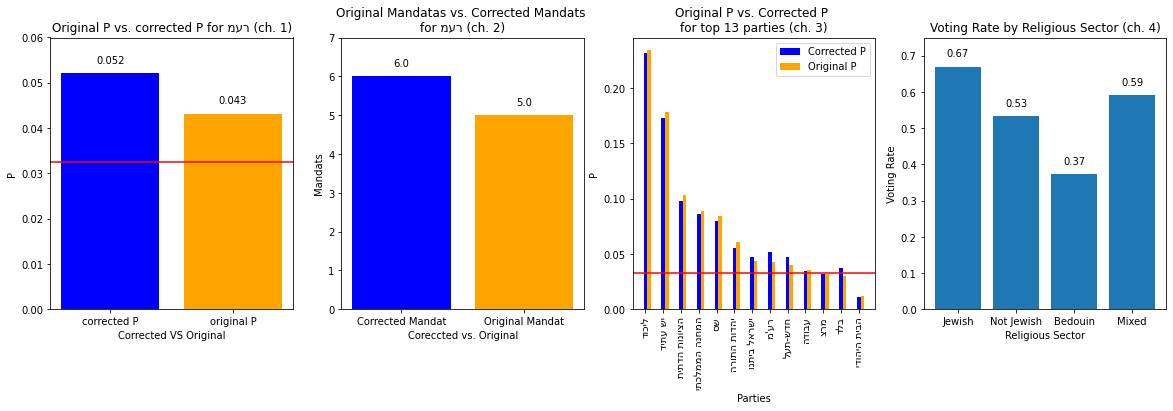

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
X = ballot_vots_if_all_df.index
X_axis = np.arange(len(X))
raam_corrected_p = pd.DataFrame(ballot_vots_if_all_df.iloc[7,:])
raam_corrected_p.index.names = ['p']
ax[0].bar(list(raam_corrected_p.index), list(raam_corrected_p.iloc[:,0]),color=['b','orange'])
ax[0].set_xlabel("Corrected VS Original")
ax[0].set_ylabel("P")
ax[0].set_title("Original P vs. corrected P for מער (ch. 1)")
ax[0].axhline(y=0.0325,color='red')
ax[0].set_ylim(0,0.06)
xticklabels = [party[::-1] for party in ballot_vots_if_all_df.index]
ax[2].bar(X_axis, ballot_vots_if_all_df['corrected P'], 0.2, label='Corrected P',
          color = 'blue')
ax[2].bar(X_axis+0.2, ballot_vots_if_all_df['original P'], 0.2, label='Original P',
          color = 'orange') 
ax[2].set_xlabel("Parties")
ax[2].set_ylabel("P")
ax[2].set_title("Original P vs. Corrected P \nfor top 13 parties (ch. 3)")
ax[2].legend()
ax[2].axhline(y=0.0325,color='red')
ax[2].set_xticks(X_axis)
ax[2].set_xticklabels(xticklabels, rotation=90)
ax[1].bar(list(raam_manda_corrected.index), list(raam_manda_corrected.iloc[:,0]),color=['b','orange'] )
ax[1].set_xlabel("Coreccted vs. Original")
ax[1].set_ylabel("Mandats")
ax[1].set_title("Original Mandatas vs. Corrected Mandats \nfor מער (ch. 2)")
ax[1].set_ylim(0,7)
city_religion_dict = {1:'Jewish',2:'Not Jewish',3:'Bedouin',4:'Mixed'}
xticklabels = [city_religion_dict[i] for i in df_ballots_2022_w_religion.index]
ax[3].bar(xticklabels, list(df_ballots_2022_w_religion.iloc[:,2]))
ax[3].set_title('Voting Rate by Religious Sector (ch. 4)')
ax[3].set_xlabel('Religious Sector')
ax[3].set_ylabel('Voting Rate')
ax[3].set_ylim(0,0.75)
for i, v in enumerate(list(raam_manda_corrected.iloc[:,0])):
    ax[1].annotate(str(v), (i, v), xytext=(0, 10), textcoords='offset points', ha='center')
for i, v in enumerate(list(raam_corrected_p.iloc[:,0])):
    ax[0].annotate(str(np.round(v,3)), (i, v), xytext=(0, 10), textcoords='offset points', ha='center')
for i, v in enumerate(list(df_ballots_2022_w_religion.iloc[:,2])):
    ax[3].annotate(str(np.round(v,2)), (i, v), xytext=(0, 10), textcoords='offset points', ha='center')

In order to estimate the corrected P AKA **what will be רעמ's voting share if all citizens with voting right would have vote** we first established the following assumption:

The voting share would distribute among all voters (בעלי זכות בחירה) the same as it distributes among the kosher votes for each ballot. Meaning the probability to vote is identical for all בעלי זכות הצבעה on a given ballot. This assumption is justified by the notion that people in the same communities share the same political views. We defined community by geographical closeness. Ballots are usually allocated by area, therefore it is a fair representation of a community.

**We will denote the above propabilty and assumption as:**

$\bf~n_{i\centerdot}$ - number of kosher votes in $\bf~ballot_{i}$; $\bf~n_{ij}$ - number of kosher votes for $\bf~party_{j}$ and $\bf~ballot_{i}$; $\bf~n$ - number of overall kosher votes; $\bf~\tilde{n}$ - number of people with the right to vote; $\bf~\alpha_{i}$ - the estimated propabilty that a suppoter of a given $\bf~party_{j}$ and given $\bf~ballot_{i}$ will vote. Based on the above assumptions: $\bf~{\hat{\alpha}_{i}}=\frac{n_{i\centerdot}}{\tilde{n}_{ij}}$ - the estimated probability that a supporter of a given $\bf~party_{j}$ and given $\bf~ballot_{i}$ will vote.

**The statistic model apply to the following distributions:** $n_{i\centerdot}=\sum_{j=1}^{K}n_{ij}\sim Bin\left(\tilde{n_{i\centerdot}},\alpha_{i}\right)$

Eventually, we are interested in estimating $\bf~\hat{q_{j}}$, which is based on the propabilty that a supporter will vote in a given $\bf~ballot_{i}$:
$\hat{q_{j}}=\frac{\sum_{i=1}^{b}n_{ij}\cdot\hat{\alpha}_{i}^{-1}}{\tilde{n}}=\frac{\sum_{i=1}^{b}n_{ij}\cdot\frac{\tilde{n_{i\centerdot}}}{n_{i\centerdot}}}{\tilde{n}}=\frac{\sum_{i=1}^{b}\hat{\tilde{n_{ij}}}}{\tilde{n}}$


Or in simpler worlds, we calculated the probability to vote in a given $\bf~ballot_{i}$ and $\bf~party_{j}$, and multiply the number of בזב in each $\bf~ballot_{i}$. Then summed it for all ballots and divided it by all בזב.

We estimated the probability that potential supporter will vote by summing רע״מs kosher votes and dividing by the number of estimated potential voters ($\bf~\tilde{n}_{j}$) after applying our model.

The advantage of this method is that it is easy to apply and the assumptions are relatively fair. Another method is to assume that the probability to vote is identical to all of the party's supporters, regardless of their geographical location. We didn't apply this method since we assumed that people have more in common with their neighbors, as it is known we behave like our environment. We also think that the political view reflects in a person's living location to some extent. 

In [ ]:
df_city_2022_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20city%202022.csv', encoding = 'utf8', index_col='סמל ישוב')
eshkol_hevrati_calcali_df = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/eshkol_hevrati_calcali.csv', encoding = 'utf8',index_col='set_code')
df_city_2021_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20city%202021.csv', encoding = 'iso-8859-8', index_col='סמל ישוב')


# merging the two datasets, in order to map the cities in which the votes were casted to socio-economic "eshkolot"
votes_and_eshkol_hevrati_calcali_2022_df = pd.concat([df_city_2022_raw, eshkol_hevrati_calcali_df], axis=1, join='inner')
votes_and_eshkol_hevrati_calcali_2022_df.head()

# Note that the join itself will result in the loss of 47 rows that did not have a matching "eshkol" status
n_rows_after_join = votes_and_eshkol_hevrati_calcali_2022_df.shape[0]
n_rows_before_join = df_city_2022_raw.shape[0]
# print("Number of rows lost due to the join with the 'eshkolot' dataset:",n_rows_before_join-n_rows_after_join)

# populate a new column that represents the votes freq out of each city
# computed as the amount of votes for the party in the city, out of the kosher votes for that city
votes_and_eshkol_hevrati_calcali_2022_df = votes_and_eshkol_hevrati_calcali_2022_df.assign(freq = lambda x: x['עם'] / x['כשרים'])

# we will select the rows in which the freq. is substantial- say, above or equal to 0.4 of the votes:
top_cities = votes_and_eshkol_hevrati_calcali_2022_df[votes_and_eshkol_hevrati_calcali_2022_df['freq'] >= 0.4]

# we will now sort the df by the freq value, in desc order, in order to find 
# the cities in which the party recieved the highest support:
top_cities_2022 = top_cities.sort_values(by='freq', ascending=False)

# hidden call for presenting the data, as we do not need to print out the 
# output and include it in our report:
#top_cities_2022[["שם ישוב", "freq"]]

# In order to get the coordinates of our top_cities, we'll query the geopy 
# library, using the following function:

def find_lat_lon(cities):
  # Create a geolocator object
  geolocator = Nominatim(user_agent="geoapiExercises", timeout=10)

  # Iterate over the list of city names
  for i,city in enumerate(cities):
      try:
          location = geolocator.geocode(city)
          print(i, location.latitude, location.longitude)
      except:
          print(f"Failed to find coordinates for {city}")

top_cities_2022_names = list(top_cities["שם ישוב"].values)

# hidden call for the function, as we do not need to print out the output and 
# include it in our report:
#find_lat_lon(top_cities_2022_names)

# merging the two datasets, in order to map the cities in which the votes were casted to socio-economic "eshkolot"
votes_and_eshkol_hevrati_calcali_2021_df = pd.concat([df_city_2021_raw, eshkol_hevrati_calcali_df], axis=1, join='inner')

# Note that the join itself will result in the loss of 47 rows that did not have a matching "eshkol" status
n_rows_after_join = votes_and_eshkol_hevrati_calcali_2021_df.shape[0]
n_rows_before_join = df_city_2021_raw.shape[0]
# print("Number of rows lost due to the join with the 'eshkolot' dataset:",n_rows_before_join-n_rows_after_join)

# populate a new column that represents the votes freq out of each city
# computed as the amount of votes for the party in the city, out of the kosher votes for that city
votes_and_eshkol_hevrati_calcali_2021_df = votes_and_eshkol_hevrati_calcali_2021_df.assign(freq = lambda x: x['עם'] / x['כשרים'])

# we will select the rows in which the freq. is substantial- say, above or equal to 0.4 of the votes:
top_cities = votes_and_eshkol_hevrati_calcali_2021_df[votes_and_eshkol_hevrati_calcali_2021_df['freq'] >= 0.4]

# we will now sort the df by the freq value, in desc order, in order to find 
# the cities in which the party recieved the highest support:
top_cities_2021 = top_cities.sort_values(by='freq', ascending=False)

# hidden call for presenting the data, as we do not need to print out the 
# output and include it in our report:
#top_cities_2021[["שם ישוב", "freq"]]

top_cities_2021_names = list(top_cities["שם ישוב"].values)

# hidden call for the function, as we do not need to print out the output and 
# include it in our report:
#find_lat_lon(top_cities_2021_names)

top_cities_data_2022 = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/top_cities_data_2022.csv', encoding = 'utf8')
top_cities_data_2021 = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/top_cities_data_2021.csv',  encoding = 'utf8')

####Section D
In order to understand and map the supporters of "Ra'am" over the election cycles in 2021 and 2022, we will analyze several parameters that may provide insight into the characteristics of the voters based on the cities they voted in (i.e where they reside). Our main focus will be on the following points of information: Geographic location of cities with highest support for the party; Socio-economic status of said cities; Peripherality index of said cities; Income per person in said cities; Inferred religious belief of the population in said cities. While some of the criteria have some overlap (e.g socio-economic status and income per person), we believe that this complementary information will provide a more comprehensive understanding of the party's supporters. 

Once we identify the top cities in terms of the highest voter turnout for "Ra'am" (taken as cities with turnout of 40% or greater), we will cross-reference this data with two pre-compiled files, one for each election year analyzed, containing supplementary information such as location (latitude and longitude coordinates), leading religion, type of settlement, mean monthly income of employed citizens, employment rate, and peripherality index data.

As we will soon demonstrate, the supporters of Ra'am are relatively homogenous, meaning they share many representative characteristics and lack diversity compared to the support base of other parties. Therefore, our focus will be on understanding their supporters, and as a result, identify areas where the party is less popular.

Firstly, to gain a comprehensive understanding of the demographic and geographic makeup of the party's voter base, we will first conduct an analysis of the cities where the majority of votes for the party were cast. 
Specifically, we will analyze the each election's data by city, taking into account only the cities that appear in the "eshkol_hevrati_calcali" dataset- i.e, have a socio-economic score.

In [ ]:
# let's present our findings on an interactive map:

from branca.element import Figure

fig = Figure(width=220, height=270)

# generating a basemap of Israel
israel = folium.Map(location=[31.0461, 34.8516], zoom_start=7)

# Create a featuregroup for 2022
elections_2022 = folium.FeatureGroup(name='2022 Elections')

# iterating over each row of the cities_df:
for index, row in top_cities_data_2022.iterrows():
    city = row['city_name_h']
    lat = row['latitude']
    lon = row['longitude']
    # Get the value of the "freq" column for this row
    freq = row['freq']

    # create a custom icon for the marker
    icon = folium.features.CircleMarker(location=[lat, lon],
                                        radius=freq*20, # size of the marker depends on the "freq"
                                        fill=True,
                                        fill_color='#3186cc',
                                        color='#3186cc',
                                        fill_opacity=0.5)
    icon.add_child(folium.Popup(city))
    icon.add_to(elections_2022)  # add the markericon to the specific feature group

# Create a featuregroup for 2021
elections_2021 = folium.FeatureGroup(name='2021 Elections')

# iterating over each row of the cities_df:
for index, row in top_cities_data_2021.iterrows():
    city = row['city_name_h']
    lat = row['latitude']
    lon = row['longitude']
    # Get the value of the "freq" column for this row
    freq = row['freq']

    # create a custom icon for the marker
    icon = folium.features.CircleMarker(location=[lat, lon],
                                        radius=freq*20, # size of the marker depends on the "freq"
                                        fill=True,
                                        fill_color='#9b59b6',
                                        color='#9b59b6',
                                        fill_opacity=0.5)
    icon.add_child(folium.Popup(city))
    icon.add_to(elections_2021)  # add the markericon to the specific feature group


elections_2022.add_to(israel)  # add the elections_2022 layer
elections_2021.add_to(israel)  # add the elections_2022 layer
folium.LayerControl().add_to(israel)  # add layer control

fig.add_child(israel)  # showcase our map

The above **interactive** map depict the top cities in terms of voter turnout for "Ra'am" in 2022 and 2021. Each circle represents a city and is sized accordingly, with larger circles indicating higher voter turnout. By comparing the two layers, we can see that many of the cities with high voter turnout for "Ra'am" remain consistent across both years. However, there are some noteworthy observations:

* In 2022, "Sachnin" is no longer considered a significant city for "Ra'am" as most of the votes were lost to "Ha-reshima Ha-meshutefet" and "Balad", the most direct competitors of "Ra'am" in this election.
* In 2022, "Ras Ali" became a significant city for "Ra'am" as they managed to gain votes that were previously held by "Ha-reshima Ha-meshutefet" and even "Ha-Likud".

As previously noted, the data was obtained from the Social Security institution and Israel's Central Bureau of Statistics. Given that the cities where "Ra'am" receives significant support are highly homogenous in terms of religious belief, we have chosen to further analyze the settlement types from which the party received votes in 2022, as represented in the accompanying pie chart.

It should be noted that according to Israel's Central Bureau of Statistics, all of the cities are classified as Muslim cities or settlements, and upon validating this manually- we only noted one exception which is that "Ras al-Ein" is **56%** Muslim and **44%** Christian. It is important to remember that the religious beliefs of the cities are assumed to be representative of the religious beliefs of the voters from said cities.

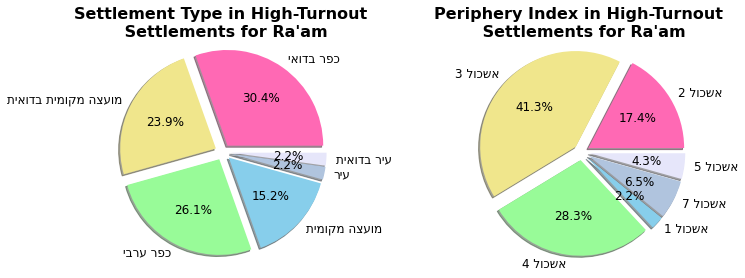

In [ ]:
# we will now create a pie chart using our aggregated data on the cities, 
# from the file we have created: "top_cities_data_2022.csv"

# prepare our data:
settlement_types = top_cities_data_2022["settlement_type"]  # our relevant data is the settelment type

# return the distinct values in our data, reversed
labels = [i[::-1] for i in Counter(settlement_types).keys()]  
# counts the freq of each value
sizes = Counter(settlement_types).values()
colors = ['#ff69b4','#f0e68c','#98fb98','#87ceeb','#b0c4de','#e6e6fa']

settlement_type = pd.DataFrame(
    {'labels': labels,
     'sizes': sizes,
     'colors': colors
    })

# 2
# prepare our data:
periphery_value = top_cities_data_2022["אשכול_פריפריאליות"]  # our relevant data is the settelment type

# return the distinct values in our data
labels2 = [f"{i} לוכשא" for i in Counter(periphery_value).keys()]
# counts the freq of each value
sizes2 = Counter(periphery_value).values()
colors2 = ['#ff69b4','#f0e68c','#98fb98','#87ceeb','#b0c4de','#e6e6fa']

periphery_eshkolot = pd.DataFrame(
    {'labels': labels2,
     'sizes': sizes2,
     'colors': colors2
    })

# create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot the first pie chart
ax[0].pie(sizes, labels=labels, radius=1.2, explode=[0.1]*6, autopct='%.1f%%', 
        shadow=True, colors=colors, textprops={'fontsize': 12})
ax[0].set_title("Settlement Type in High-Turnout \n Settlements for Ra'am",
                fontsize=16, y=1.05, weight='bold')

# plot the second pie chart
ax[1].pie(sizes2, labels=labels2, radius=1.2, explode=[0.1]*6, autopct='%.1f%%', 
        shadow=True, colors=colors2, textprops={'fontsize': 12})
ax[1].set_title("Periphery Index in High-Turnout \n Settlements for Ra'am",
                fontsize=16, y=1.05, weight='bold')

fig.subplots_adjust(wspace=0.8, hspace=0.3)
plt.show()

Similarly, we will analyze the distribution of votes per monthly income among the employed citizens in the top cities for "Ra'am" (where data is available). 
This information will be presented in the form of a bar plot and will also include the employment rate for each city (in gray, above the bars). It is important to note that this data represents the average income of employed individuals and the actual average monthly income per person in the city may be lower, as it does not take into account unemployment or individuals who are not of working age.

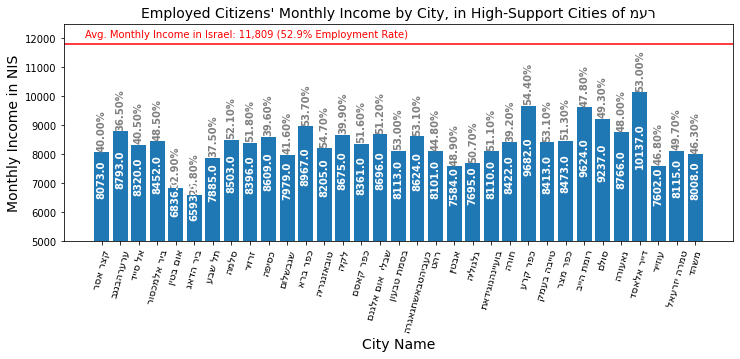

In [ ]:
from textwrap import wrap

# drop rows without the relevant data
barplot_cities_data = top_cities_data_2022[top_cities_data_2022["employment_rate"] != "?"].copy()
barplot_cities_data = barplot_cities_data.reset_index(drop=True)  # reset the index of the df
barplot_cities_data['monthly_income_nis'] = barplot_cities_data['monthly_income_nis'].astype(float)


labels = [i[::-1] for i in barplot_cities_data['city_name_h']]

plt.figure(figsize=(12,4))
plt.bar(range(len(labels)), barplot_cities_data['monthly_income_nis'])
plt.xlabel("City Name", fontsize=14)
plt.ylabel("Monthly Income in NIS", fontsize=14)

bar_width = 1
for i, v in barplot_cities_data.iterrows():
  # add the employment rate in each city
  plt.text(i, v['monthly_income_nis']+100, str(v['employment_rate']), 
          color='gray', fontweight='bold', ha="center", rotation=90)
  # add the actual value of the monthly inclome on top of each bar
  plt.text(i, (v['monthly_income_nis']/2) + 2500, str(v['monthly_income_nis']), 
          color='white', fontweight='bold', ha="center", rotation=90)


plt.title("Employed Citizens' Monthly Income by City, in High-Support Cities of מער", fontsize=14)
# add a horizontal line reprenting the average monthly income in Israel
plt.axhline(y=11809, color="red")
plt.text(len(labels)/2, 12009, "Avg. Monthly Income in Israel: 11,809 (52.9% Employment Rate)", color="red", ha="right")

plt.ylim(5000, 12500)
plt.xticks(range(len(labels)), labels, rotation=75)
plt.show()

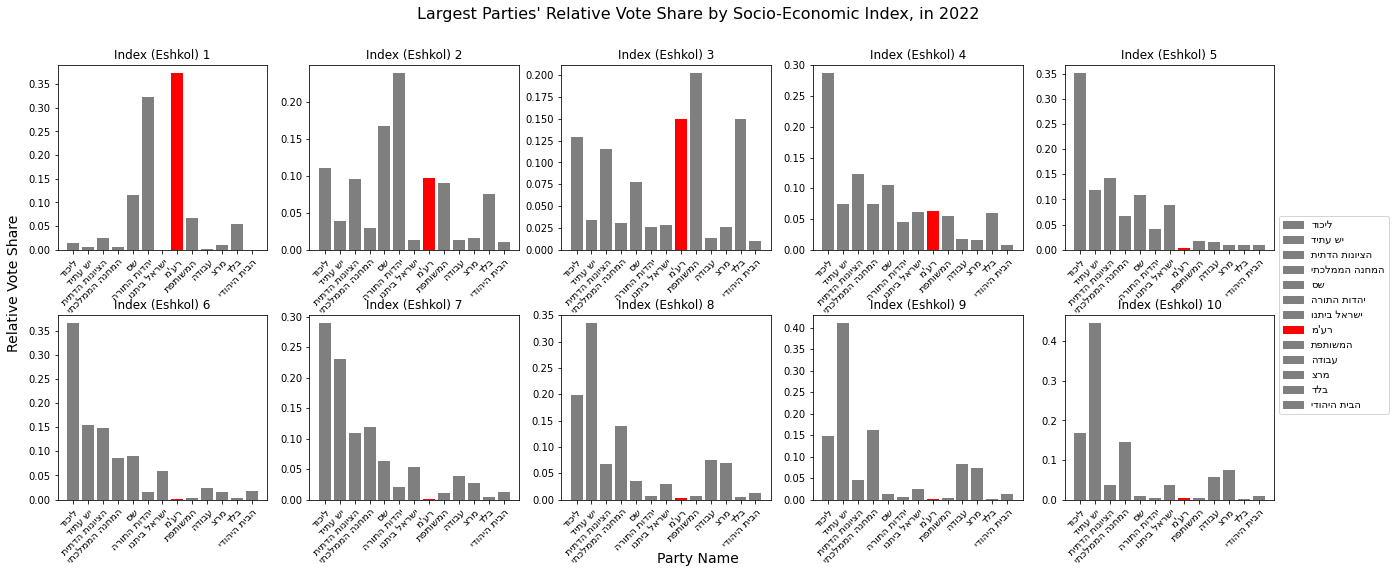

In [ ]:
# letters to parties name dictionary 
parties_letters_to_name_dict =   {"אמת":"עבודה", "ב":"הבית היהודי", "ג":"יהדות התורה","ום":"המשותפת","ט":"הציונות הדתית","כן":"המחנה הממלכתי"
,"ל":"ישראל ביתנו","מחל":"ליכוד","מרצ":"מרצ","עם":"רע'מ","פה":"יש עתיד","ודעם":"המשותפת","שס":"שס","ד":"בלד"}

top_13_parties = ['מחל', 'פה', 'ט', 'כן', 'שס', 'ג', 'ל', 'עם', 'ום', 'אמת', 'מרצ', 'ד', 'ב']

for party in parties_letters_to_name_dict:  # labels were reversed
  parties_letters_to_name_dict[party] = parties_letters_to_name_dict[party][::-1]

def plot_votes_per_party_by_eshkol(eshkol_votes_df, year):

    fig = plt.figure(figsize=(20,8))
    axes = fig.subplots(nrows=2, ncols=5)

    for idx,ax in zip(range(1, 11), axes.flatten()):
    
      grouped_df = eshkol_votes_df.groupby("eco_level").get_group(idx)
      
      # relative freq of votes per party, for said group:
      total_rel_freq = dict()
      for party in top_13_parties:  # calc the relative freq. per party in the eshkol
          total_rel_freq[party] = [grouped_df[party].sum() / grouped_df["כשרים"].sum()]
      votes_in_eshkol = pd.DataFrame.from_dict(total_rel_freq, orient="columns")  # convert to df
      
      votes_in_eshkol = votes_in_eshkol.rename(columns=parties_letters_to_name_dict)
      
      colors =['#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f','r', '#7f7f7f', '#7f7f7f','#7f7f7f', '#7f7f7f', '#7f7f7f']

      ax.bar(votes_in_eshkol.columns.tolist(), votes_in_eshkol.loc[[0]].values.tolist()[0], color=colors)
      ax.title.set_text('Index (Eshkol) {}'.format(idx))
      
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
      plt.subplots_adjust(left=0.055, hspace=0.35)
    
    labels = ['דוכיל', 'דיתע שי', 'תיתדה תונויצה', 'יתכלממה הנחמה', 'סש', 'הרותה תודהי', 'ונתיב לארשי', "מ'ער", 'תפתושמה', 'הדובע', 'צרמ', 'דלב', 'ידוהיה תיבה']
    colors = dict(zip(labels, colors))

    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 1))

    fig.suptitle("Largest Parties' Relative Vote Share by Socio-Economic Index, in {}".format(year), fontsize=16)
    fig.supxlabel("Party Name", fontsize=14)
    fig.supylabel("Relative Vote Share", fontsize=14)
    plt.show()


plot_votes_per_party_by_eshkol(votes_and_eshkol_hevrati_calcali_2022_df, 2022)

Now we will turn to analyze the entire datasets (and not just the subset of cities with the leading support rate or Ra'am).

To understand the socio-economic class of Ra'am's supporters, we will analyze the share of votes the party received in relation to the socio-economic index values. Specifically, we will calculate the total sum of votes the party received in each index value, as a percentage of all kosher votes in that index value. This will be presented in a bar chart to visualize the distribution of support among different socio-economic classes.

To further explore the socio-economic class of "Ra'am" supporters, we will analyze the vote share of the party in relation to the socio-economic index values in both the 2021 and 2022 election cycles. Specifically, we will calculate the total sum of votes the party received in each index value, as a percentage of all valid votes in that index value. This data will be presented in a bar chart and color-coded based on the difference in support between the two election cycles, with red indicating a loss of support and green indicating an increase in support:

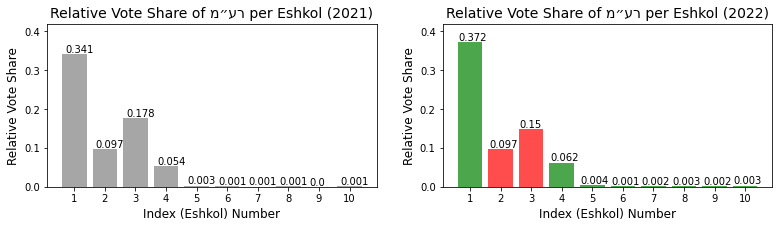

In [ ]:
# merging the two datasets, in order to map the cities in which the votes were casted to socio-economic "eshkolot"
votes_and_eshkol_hevrati_calcali_2021_df = pd.concat([df_city_2021_raw, eshkol_hevrati_calcali_df], axis=1, join='inner')
votes_and_eshkol_hevrati_calcali_2021_df.head()

# Note that the join itself will result in the loss of 44 rows that did not have a matching "eshkol" status
n_rows_after_join = votes_and_eshkol_hevrati_calcali_2021_df.shape[0]
n_rows_before_join = df_city_2021_raw.shape[0]
# print("Number of rows lost due to the join with the 'eshkolot' dataset:",n_rows_before_join-n_rows_after_join)

# calculate the relative vote share for "רע״מ", per eshkol of each year:
total_rel_freq_2021, total_rel_freq_2022 = [], []

for eshkol in range(1,11):
  # 2022
  grouped_df_2022 = votes_and_eshkol_hevrati_calcali_2022_df.groupby("eco_level").get_group(eshkol)  # group per eshkol
  total_rel_freq_2022.append([grouped_df_2022["עם"].sum() / grouped_df_2022["כשרים"].sum()][0])  # get rel. freq. of votes of party in that eshkol
  # 2021
  grouped_df_2021 = votes_and_eshkol_hevrati_calcali_2021_df.groupby("eco_level").get_group(eshkol)  # group per eshkol
  total_rel_freq_2021.append([grouped_df_2021["עם"].sum() / grouped_df_2021["כשרים"].sum()][0])  # get rel. freq. of votes of party in that eshkol


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

# plot 2021
ax1.bar([str(i) for i in range(1,11)], total_rel_freq_2021, color='gray', alpha=0.7)
ax1.set_title("Relative Vote Share of {} per Eshkol ({})".format("רע״מ"[::-1], 2021), fontsize=14)
ax1.set_xlabel('Index (Eshkol) Number', fontsize=12)
ax1.set_ylabel('Relative Vote Share', fontsize=12)
ax1.set_ylim(0, 0.42)

# Add label of of the actual relative vote share per eshkol for 2021 data
for index, data in enumerate(total_rel_freq_2021):
    ax1.annotate(text=f"{round(data,3)}", xy=(index, data), xytext=(index-0.3, data+0.004), fontsize=10)

# plot 2022
# color based on 2021 values
colors = ["green" if total_rel_freq_2022[i] > total_rel_freq_2021[i] else "red" for i in range(len(total_rel_freq_2021))]

ax2.bar([str(i) for i in range(1,11)], total_rel_freq_2022, color=colors, alpha=0.7)
ax2.set_title("Relative Vote Share of {} per Eshkol ({})".format("רע״מ"[::-1], 2022), fontsize=14)
ax2.set_xlabel('Index (Eshkol) Number', fontsize=12)
ax2.set_ylabel('Relative Vote Share', fontsize=12)
ax2.set_ylim(0, 0.42)

# Add label of of the actual relative vote share per eshkol for 2022 data
for index, data in enumerate(total_rel_freq_2022):
    ax2.annotate(text=f"{round(data,3)}", xy=(index, data), xytext=(index-0.38, data+0.004), fontsize=10)

plt.show()

To summarize, the vast majority of the supporters of "Ra'am" appear to be primarily Muslim, residing in Arab settlements (including Bedouin settlements) that have low socio-economic status, low income per person, and are located in peripheral areas. Additionally, their supporters' charachteristics are quite homogenous, the entirty of the group can be described using the above charachteristics.

On the other hand, "Ra'am" is crealy lacking support and diversity in every other field- cities of higher socio-economic status, voters of other religious beliefs, from Jewish cities or mixed settelemtns, etc.

This is supported by the data analyzed in terms of settlement types, religious beliefs, and socio-economic indices.

#### Section E
We will now showcase the votes the party "Ra'am" received per ballot, using the projection of the votes per ballot (via PCA) on a 2-D dimension.

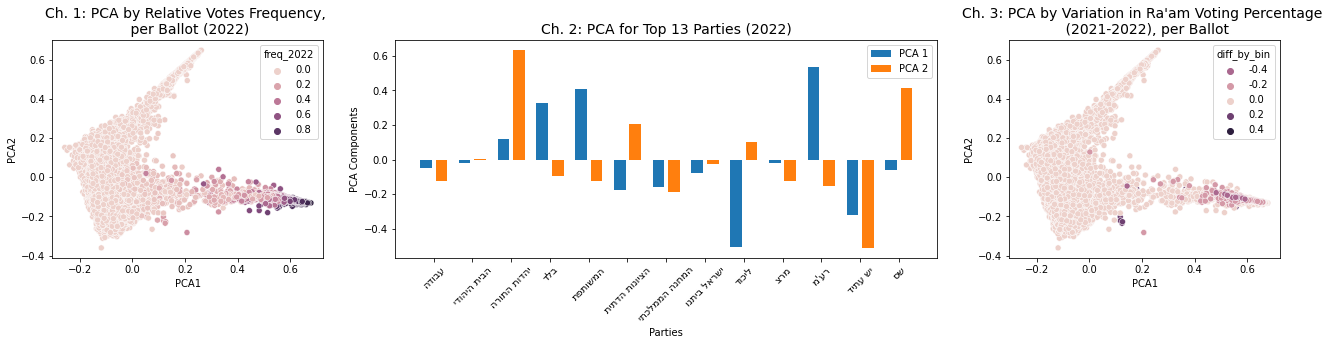

In [ ]:
df_ballots_2021_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202021.csv', encoding = 'iso-8859-8', index_col="ברזל")
df_ballots_2021 = df_ballots_2021_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
df_ballots_2021 = df_ballots_2021[df_ballots_2021['שם ישוב']!='מעטפות חיצוניות']  # exclude מעטפות חיצוניות

df_ballots_2022_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202022.csv',  encoding = 'utf8', index_col="ברזל")
df_ballots_2022 = df_ballots_2022_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
df_ballots_2022 = df_ballots_2022[df_ballots_2022['שם ישוב']!='מעטפות חיצוניות']
df_ballots_2022_copy = df_ballots_2022.iloc[:,8:]

#normlize votes frequencies to sum =1 (for the PCA calculation)
df_ballots_2022_normalized = df_ballots_2022_copy.iloc[:,1:].div(df_ballots_2022_copy.iloc[:,0],axis=0)

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 3, figsize=(22, 4), gridspec_kw={'width_ratios': [0.7, 1.4, 0.7]})

pca = PCA(n_components=2)  # define PCA object 
pca_df_ballots_2022 = pca.fit_transform(df_ballots_2022_normalized)  # fit model, compute principal components

# add vote share info to PCA
# populate a new column that is the rel. vote share of "רעמ":
df_ballots_2022["freq_2022"] = df_ballots_2022["עם"] / df_ballots_2022["כשרים"]

# paste the PCA data
df_ballots_2022['PCA1'] = pca_df_ballots_2022[:,0]
df_ballots_2022['PCA2'] = pca_df_ballots_2022[:,1]

# plot PCA for "רעמ", colored by the votes share in each ballot:
sns.scatterplot(data=df_ballots_2022, x="PCA1", y="PCA2", hue="freq_2022", ax=ax[0])

ax[0].set_title(f"Ch. 1: PCA by Relative Votes Frequency, \n per Ballot (2022)", fontsize=14)

# letters to parties name dictionary 
letter_to_p_dict ={"אמת":"עבודה", "ב":"הבית היהודי", "ג":"יהדות התורה","ום":"המשותפת","ט":"הציונות הדתית","כן":"המחנה הממלכתי"
,"ל":"ישראל ביתנו","מחל":"ליכוד","מרצ":"מרצ","עם":"רע'מ","פה":"יש עתיד","ודעם":"המשותפת","שס":"שס","ד":"בלד"
,"אצ":"חופש כלכלי","ז":"שחר כוח חברתי","זך":"קמה","זנ":"כח להשפיע","זץ":"צומת","י":"ישראל חופשית דמוקרטית",
"יז":"הכלכלית החדשה","ינ":"איחוד בני הברית","יץ":"צו השעה","יק":"מפלגת הגוש התנכי","ך":"אני ואתה","נז":"כבוד האדם",
"ני":"נתיב","נף":"מפלגת שמע","נץ":"העצמאים החדשים","נק":"יש כיוון","נר":"אנחנו","ף":"הפיראטים","צ":"צעירים בוערים",
"ץ":"מנהיגות חברתית","ק":"קול הסביבה והחי","קי":"הלב היהודי","קך":"סדר חדש","קנ":"כל קול קובע","קץ":"באומץ בשבילך",
"רז":"רשימת שלושים\ארבעים","ת":"דעת טוב ורע וברית שבט אברהם-עלה ירוק"}

# retrive top 13 parties
ballots_2022_kosher_and_votes = df_ballots_2022.iloc[:,8:]
over_all_p = ballots_2022_kosher_and_votes.drop(columns=['כשרים']).select_dtypes(include=['number']).sum()/sum(ballots_2022_kosher_and_votes['כשרים'])
top_13 = over_all_p.sort_values(ascending=False)[0:13]
top_13 = [letter_to_p_dict[party] for party in top_13.index]

pca_first_component_nrom = pca.components_[0]/np.linalg.norm(pca.components_[0],2)
pca_second_component_nrom = pca.components_[1]/np.linalg.norm(pca.components_[0],2)
pca_comp_df = pd.DataFrame({'party': [letter_to_p_dict[party] for party in df_ballots_2022_normalized.columns],
                            'PCA1':pca_first_component_nrom,
                            'PCA2':pca_second_component_nrom})

# plot PCA components for top 13 parties
pca_comp_top_13_df = pca_comp_df[pca_comp_df['party'].isin(top_13)]

X_axis = np.arange(len(pca_comp_top_13_df['party']))
ax[1].bar(X_axis - 0.2, pca_comp_top_13_df['PCA1'], 0.3, label = 'PCA 1')
ax[1].bar(X_axis + 0.2, pca_comp_top_13_df['PCA2'], 0.3, label = 'PCA 2')
  
ax[1].set_xticks(X_axis, list(map(lambda i : i[::-1], pca_comp_top_13_df['party'])), rotation=45)
ax[1].set_xlabel("Parties")
ax[1].set_ylabel("PCA Components")
ax[1].set_title("Ch. 2: PCA for Top 13 Parties (2022)", fontsize=14)
ax[1].legend()

df_ballots_2021_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202021.csv', encoding = 'iso-8859-8', index_col="ברזל")
df_ballots_2021 = df_ballots_2021_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
df_ballots_2021 = df_ballots_2021[df_ballots_2021['שם ישוב']!='מעטפות חיצוניות']  # exclude מעטפות חיצוניות

cols = ["עם", "שם ישוב", 'פסולים', 'קלפי', 'בזב', 'כשרים','סמל ישוב']

df_ballots_2021 = df_ballots_2021[cols].reset_index()

cols = ["עם", "שם ישוב", 'פסולים', 'קלפי', 'בזב', 'כשרים','סמל ישוב', "PCA1", "PCA2"]
df_ballots_2022 = df_ballots_2022[cols].reset_index()

ballot_match = df_ballots_2021.set_index(['קלפי', 'סמל ישוב']).join(df_ballots_2022.set_index(['קלפי', 'סמל ישוב']), lsuffix = '-2021').dropna()

ballot_match["freq_2021"] = ballot_match["עם-2021"] / ballot_match["כשרים-2021"]
ballot_match["freq_2022"] = ballot_match["עם"] / ballot_match["כשרים"]
ballot_match["diff"] = ballot_match["freq_2022"] - ballot_match["freq_2021"]
ballot_match.sort_values(by="diff", ascending=False, inplace=True)

df_ballots_2022 = df_ballots_2022.set_index(["קלפי", "סמל ישוב"])

df_ballots_2022 = pd.merge(df_ballots_2022, ballot_match[["diff"]], left_index=True, right_index=True, how='left')

df_ballots_2022["diff"].fillna(0, inplace=True)
df_ballots_2022.sort_values(by="diff", ascending=False, inplace=True)

# categorize our diff column per the same bins, in order to match the new color palatte to it
labels = ["-0.4", "-0.2", "0.0", "0.2", "0.4"]

df_ballots_2022["diff_by_bin"] = pd.cut(df_ballots_2022["diff"], bins=5, labels=labels)

# set a new color palette, to make the following plot more informative
new_colors_order = sns.cubehelix_palette(n_colors=5)
new_colors_order[0], new_colors_order[2] = new_colors_order[2], new_colors_order[0]

# plot PCA for colored by variation in voting percentage in each ballot:
sns.scatterplot(data=df_ballots_2022, x="PCA1", y="PCA2", hue="diff_by_bin", palette=new_colors_order, ax=ax[2])

ax[2].set_title(f"Ch. 3: PCA by Variation in Ra'am Voting Percentage \n (2021-2022), per Ballot", fontsize=14)

plt.show()

Upon examination of the above plots, the following observations can be made:

* Chart 2 shows that the parties with the highest positive values for the first component (PCA1) are Arab parties- "Ra'am", "Ha-meshutefet", and "Balad". Conversely, parties with significant negative values for the first component are the two largest parties in the entire election cycle- "Ha-Likud" and "Yesh-Atid".
    * It can be speculated that this principal component (PC) represents the party's affinity with Arab voters, which explains the high values received by Arab parties. Alternatively, it may represent the homogeneity or heterogeneity of the party's voter base, which also explains the low values received by the largest parties.
* Chart 2 also shows that parties with the highest positive values for the second component (PCA2) are right-wing and Orthodox parties, such as "Yehadut Ha-torah", "Shas", "Ha-tziuonut Ha-datit". Conversely, parties with negative values for the second component are considered to be leaning more towards the left-wing, such as "Yesh-Atid", "Avoda", "Meretz", etc.
    * It can be speculated that this PC represents the party's affinity with Orthodox beliefs, which explains the high values received by Jewish Orthodox parties. Alternatively, it may represent the socio-economic index of the majority of the party's supporters' cities, from low to high, which also explains the low values received by parties leaning more towards the left-wing.
* Chart 1 demonstrates that the majority of ballots in which "Ra'am" received the most support are located on the lower "tail" of the PCA projection, where the PCA1 values are the highest. This aligns with the fact that "Ra'am" is an Arab party with a very homogeneous support base.
* Chart 3 suggests that the voting percentage difference of Ra'am between the 2022 and 2021 was not substantial. It seems as it was mostly consistent between the election cycles, and when there were changes in the voting rate it was mostly a slight decrease in support, which is consistent with our previous findings.

Please note that the above observations are supported by previous analysis conducted using additional exploratory analysis of the principal component analysis (PCA) for this dataset in Labs 6 and 7. For example, by coloring the plot based on socio-economic index values or vote share per party, as extensively demonstrated in Labs 6 and 7.

The change in voting percentage between 2022 and 2021 were calculated as the percentage of valid votes cast out of the total eligible voters ("bzb"). Also, the data for the 2022 elections serves as the reference point for this comparison, and only the 2021 election data that aligns with our 2022 data (in terms of ballots) will be considered.

Our findings align with the analysis presented in the previous section, as the representation and color-coding of the "Ra'am" party's data confirms the demographic characteristics of the party's supporters as previously determined.

**PCA**

When exploring the raw voting data in the various election cycles, it is often time difficult to draw meaningful conclusions regarding the voting patterns in the data, as it simply is too large.

To that end, we will utilize a technique called PCA. This method involves reducing the dimensionality of the dataset by identifying linear combinations of the original variables, called PCs, that explain the most variance in the data. This allows us to effectively condense the data while preserving its informative value. The goal is to identify the main components of the data, making it easier to visualize and draw meaningful conclusions.

* Mathematically, given the votes per ballot dataset (X) with n samples (number of ballots) and p features (number of parties), we samples using a linear subspace $B ⊂ R^p $ with $ dim(B) = k ≪ p$. The projection
of each vector $x_i$ onto $B$ is denoted $TB(x_i)$, as follows:
$$TB(x) = argmin_{x′ ∈ B} ||x − x'||^{2}_{2}$$
* This, in fact, is merely an opitimization problem: we're looking for the subspace $B$ that minimizes the distance between the points and their projection. The method to resolve this (using SVD) is out of the course's scope.

In [ ]:
path= "/content/drive/MyDrive/Colab Notebooks/votes per ballot 2022.csv"
df_ballots_2022_raw = pd.read_csv(path, encoding = 'utf8', index_col='ברזל')
df_ballots_2022 = df_ballots_2022_raw[df_ballots_2022_raw['שם ישוב']!='מעטפות חיצוניות']  # removing "metadata" columns


path= "/content/drive/MyDrive/Colab Notebooks/votes per ballot 2021.csv"
df_ballots_2021_raw = pd.read_csv(path, encoding = 'iso-8859-8', index_col='ברזל')
df_ballots_2021 = df_ballots_2021_raw[df_ballots_2021_raw['שם ישוב']!='מעטפות חיצוניות']  # removing "metadata" columns
df_ballots_2021 = df_ballots_2021.loc[:,df_ballots_2021.columns[:-1]]

over_all_p_2022 = df_ballots_2022[list(df_ballots_2022.columns[10:])].sum()/sum(df_ballots_2022['כשרים'])  # calculate real p 
over_all_p_2021 = df_ballots_2021[list(df_ballots_2021.columns[10:])].sum()/sum(df_ballots_2021['כשרים'])  # calculate real p
over_all_p_2020 = df_ballots_2020[list(df_ballots_2020.columns[10:])].sum()/sum(df_ballots_2020['כשרים'])  # calculate real p

top_13_2022 = over_all_p_2022.sort_values(ascending=False)[0:13]
top_13_2021 = over_all_p_2021.sort_values(ascending=False)[0:13]


df_ballots_2022['לא הצביעו'] = df_ballots_2022_raw['בזב'] - df_ballots_2022_raw['פסולים']-df_ballots_2022_raw['כשרים']
df_ballots_2021['לא הצביעו'] = df_ballots_2021_raw['בזב'] - df_ballots_2021_raw['פסולים']-df_ballots_2021_raw['כשרים']
#parties_2021 = list(df_ballots_2021.columns[10:])
#parties_2022 = list(df_ballots_2022.columns[10:])
df_merged_ballots = pd.merge(df_ballots_2021.loc[:,['קלפי','שם ישוב','לא הצביעו']+list(top_13_2021.index)]
                              ,df_ballots_2022.loc[:,['קלפי','שם ישוב','לא הצביעו']+list(top_13_2022.index)]
                              ,how='inner', on=['שם ישוב', 'קלפי'], suffixes=('_2021', '_2022'))

def separate_df_to_na_nb(df,c):
  na = df.iloc[:,2:c]
  nb = df.iloc[:,c:]
  return na,nb


def apply_constrains(m_hat,na,nb):
  m_hat = pd.DataFrame(np.where(m_hat <0.005, 0, m_hat),index = na.columns)
  m_hat.columns = nb.columns
  m_hat = m_hat.div(m_hat.sum(axis=1),axis='rows')

  m_hat.columns = m_hat.columns.str.replace(r'_2022', '')
  m_hat.index = list(map(lambda st: str.replace(st, "_2021", ""), m_hat.index))
  return m_hat

def apply_ols(na,nb):
  m_hat = np.dot(np.dot(np.linalg.pinv(np.dot(na.T,na)),na.T),nb)
  return apply_constrains(m_hat,na,nb)

def apply_nnls(na,nb):
  m_hat_nnls = []
  
  for p in nb.columns:
    m_hat_nnls.append(list(nnls(na, nb[p])[0]))
  
  m_hat_nnls_df = apply_constrains(np.array(m_hat_nnls).T,na,nb)
  return m_hat_nnls_df

# (using the template from https://plotly.com/python/sankey-diagram/)


colors = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
                  "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
                  "#1A55FF", "#98DF8A", "#FF9896", "#AEC7E8", "#FFBB78"]

def plot_sankey(change_matrix, labels,colors):

  # set our plot colors
  

  # the sankey plot requires a start and end indices (source and tagret), which
  # in our case are the indices of the combinations of pairs of parties:
  source_indices = []
  for i in range(len(labels) // 2):
      for j in range(len(labels) // 2):
          source_indices.append(i)

  target_indices = []
  for i in range(len(labels) // 2):
      for j in range(len(labels) // 2, len(labels)):
          target_indices.append(j)

  # create a list of the colors matching each value in the change_matrix, by index
  color_per_index = [colors[i] for i in source_indices]

  opacity = 0.4
  
  # the first half of the colors list will be used to color the nodes:
  node_colors = 2 * colors[:len(labels)//2]
  # a subset of the color_per_index list will be used to color the links:
  link_colors = color_per_index[:(len(labels)//2)**2]

  fig = go.Sankey(
                valueformat=".3f",
                valuesuffix="%",
                
                node = dict(  # Define nodes
                  pad=15,
                  thickness=20,
                  line=dict(color="black", width=0.2),
                  label=labels,
                  color=node_colors
                  ),
                
                link=dict(  # Add links
                  source=source_indices,
                  target=target_indices,
                  value=change_matrix,
                  color=link_colors
                  )
                )
  return fig

na,nb = separate_df_to_na_nb(df_merged_ballots,16)
m_hat_df = apply_nnls(na,nb)

col_order = list(m_hat_df.columns)
col_order.remove('עם')
col_order = ['עם']+col_order
row_order = list(m_hat_df.index)
row_order.remove('עם')
row_order = ['עם']+row_order
m_hat_df = m_hat_df.loc[row_order,col_order]
change_matrix_snakey = m_hat_df.copy()
change_matrix_snakey.iloc[1:,1:]=0
title = "Transition of Votes From רעמ at the 2021 Elections to Other Parties at the 2022 Elections (chart #1)"
# flatten our matrix in order for it to properly fit into our func (df->list)
change_matrix_snakey.rename(columns=parties_letters_to_name_dict_2022, inplace=True)
change_matrix_snakey.rename(index=parties_letters_to_name_dict_2021, inplace=True)
labels = list(change_matrix_snakey.index) + list(change_matrix_snakey.columns)
change_matrix_snakey = np.array(change_matrix_snakey).flatten().tolist()

#### Sections F and G

This section examines the transition of voters between two election rounds (the 2021 elections to the 2022 elections). We are interested in understanding the voter's movements from party to party between the two elections since it could indicate on changes in the parties' support population. In order to estimate the % transition from party to party, we used the Markov chain method, which will be explained in detail later.


**~86.5%** of רע״מ's voters from the 2021 elections voted to רע״מ in the 2022 elections as well (chart #2). רע״מ lost **~10.4%** to בלד, and **~3.2%** to חדש-תעל(chart #2), while gained less then **1%** from מרצ and non voters (chart #3).

When splitting the ballots by אשכול חברתי כלכלי, we can see that the estimates transitions change dramatically.
For Eshkolot 1-5, the transition **from** רע״מ stays about the same (chart #5), but the estimated % transition from מרצ grew from less than **1%** to **~12.6%** (chart #4). While for Eshkolot 6-10, it looks completely different. Only **~40%** of רע״מ's votes in the 2021 elections transitioned to רע״מ in the 2022 elections, while **~55%** transitioned to בלד* (chart #6,#7).
It indicates a change in the political view of voters from higher socioeconomic status.


* רע״מs sample size from Eshkolot 6-10 is relatively small, therefor the effect is not notable, but we will validate it in the next section.  

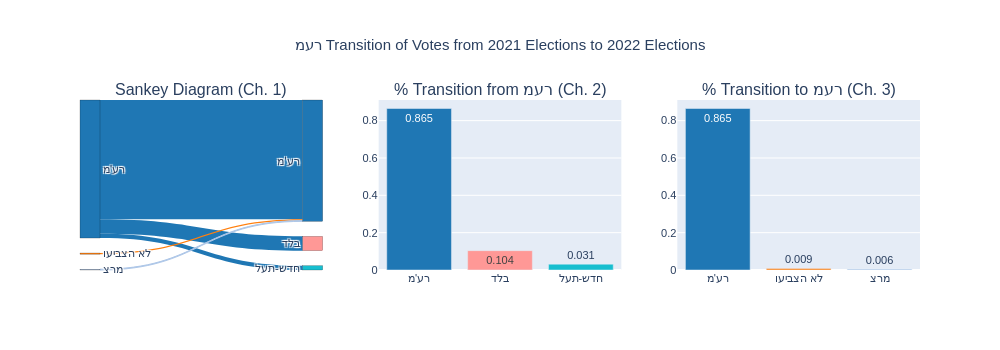

In [ ]:
change_matrix_from = m_hat_df.loc['עם',m_hat_df.loc['עם',:]>0]
change_matrix_to = m_hat_df.loc[m_hat_df.loc[:,'עם']>0,'עם']
change_matrix_from.sort_values(ascending= False,inplace=True)
change_matrix_to.sort_values(ascending= False,inplace=True)
title = "רעמ Transition of Votes from 2021 Elections to 2022 Elections"
lables_from = [parties_letters_to_name_dict_2022[party] for party in change_matrix_from.index]
lables_to = [parties_letters_to_name_dict_2021[party] for party in change_matrix_to.index]
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=['Sankey Diagram (Ch. 1)',
                                    '% Transition from רעמ (Ch. 2)', 
                                    '% Transition to רעמ (Ch. 3)'],
                    specs=[[{'type':'sankey'},{"type":"bar"}, {"type":"bar"}]])
fig.add_trace(plot_sankey(change_matrix_snakey, labels,colors), row=1, col=1)

fig.add_trace(go.Bar(x=lables_from, y=change_matrix_from,text =np.round(change_matrix_from,3)),
                row=1, col=2)
fig.add_trace(go.Bar(x=lables_to, y=change_matrix_to,text=np.round(change_matrix_to,3)), row=1, col=3)
fig.update_traces(marker_color=['#1F77B4','#FF9896','#17BECF'], row=1, col=2)
fig.update_traces(marker_color=['#1F77B4','#FF7F0E','#AEC7E8'], row=1, col=3)
fig.update_layout(title_text=title, font_size=11,title_x=0.5,showlegend=False,autosize=False,
          width=1000,height=350)
fig.show(renderer="png")

In order to estimate the transitions from the 2021 elections to the 2022 elections we modeled it as Markov chains, but since the data sets are not at the individual level, we don't have the precise transactions. Each row in the data sets represents a ballot and each column represents the number of votes to a given party. Hence we can model the data as a linear equation of the following:
$\bf~N_{a}M+𝛆 = N_{b}$; $\bf~n$ - number of ballots (rows); $\bf~K$ - number of parties; $\bf~N_{a}\in\mathbb{N}^{n\times K}$ - 2021 ballon election; $\bf~N_{b}\in\mathbb{N}^{n\times K}$- 2022 ballon election; $\bf~N=\left(N_{a},N_{b}\right)$

The solution that minimizes the above equation is:
$\bf~\hat{M} = argmin_M \mid\mid N^{(a)}M+𝛆 = N^{(b)} \mid \mid_F^2$

Our main assumptions besides the ones stated above are that each voter can only vote once for one party and that parties can change from elections to elections. In this report, we chose to use the NNLS solution, with the following constraints on $\bf~\hat{M}$
1. Truncated all $\bf~\hat{M}_{ij}<0.005$
2. Normalized each row in $\bf~\hat{M}$ to be a total of 1 (in accordance with the Markov chain transition matrix).

Previous analysis (Lab 9) showed that $\bf~\hat{M}_{ij}$ is not substantially different between OLS regression and NNLS with the above constraints. Furthermore (as will be shown in the next section), there are no meaningful differences in MSE between the two methods. Nevertheless, we preferred applying NNLS as it forces a priorly that all elements will be non-negative. We also applied the model to a subset of the data and looked only at the top 13 parties + non-voters. We assumed that non-voters will demonstrate a similar behavior in terms of "loyalty" (not voting in both elections). The top 13 and non-voters constitute about 99% of the votes, therefore it explains most of the transitions on one hand, and simplifies the model on the other.

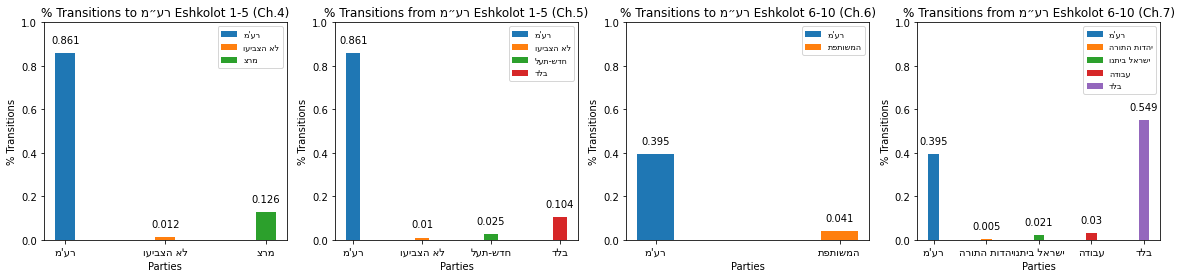

In [ ]:
path= "/content/drive/MyDrive/Colab Notebooks/eshkol_hevrati_calcali.csv"
eshkol_hevrati_calcali_df = pd.read_csv(path, encoding = 'utf8')


df_merged_ballots_w_features = (pd.merge(df_ballots_2021.loc[:,['קלפי','סמל ישוב','לא הצביעו']+list(top_13_2021.index)]
                              ,df_ballots_2022.loc[:,['קלפי','סמל ישוב','לא הצביעו']+list(top_13_2022.index)]
                              ,how='inner', on=['סמל ישוב', 'קלפי'], suffixes=('_2021', '_2022'))).merge(eshkol_hevrati_calcali_df[['eco_level','set_code']], 
                                                  left_on='סמל ישוב', right_on='set_code')
df_merged_low = df_merged_ballots_w_features.loc[df_merged_ballots_w_features['eco_level']<=5,df_merged_ballots_w_features.columns[:-2]]
na_low,nb_low = separate_df_to_na_nb(df_merged_low,16)
m_hat_df_low = apply_nnls(na_low,nb_low)
df_merged_high = df_merged_ballots_w_features.loc[df_merged_ballots_w_features['eco_level']>5,df_merged_ballots_w_features.columns[:-2]]
na_high,nb_high = separate_df_to_na_nb(df_merged_high,16)
m_hat_df_high = apply_nnls(na_high,nb_high)

col_order_high = list(m_hat_df_high.columns)
col_order_high.remove('עם')
col_order_high = ['עם']+col_order_high
row_order_high = list(m_hat_df_high.index)
row_order_high.remove('עם')
row_order_high = ['עם']+row_order_high
m_hat_df_high = m_hat_df_high.loc[row_order_high,col_order_high]
change_matrix_snakey_high = m_hat_df_high.copy()
change_matrix_snakey_high.iloc[1:,1:]=0
# flatten our matrix in order for it to properly fit into our func (df->list)
change_matrix_snakey_high.rename(columns=parties_letters_to_name_dict_2022, inplace=True)
change_matrix_snakey_high.rename(index=parties_letters_to_name_dict_2021, inplace=True)
labels = list(change_matrix_snakey_high.index) + list(change_matrix_snakey_high.columns)
change_matrix_snakey_high = np.array(change_matrix_snakey_high).flatten().tolist()

col_order_low = list(m_hat_df_low.columns)
col_order_low.remove('עם')
col_order_low = ['עם']+col_order_low
row_order_low = list(m_hat_df_low.index)
row_order_low.remove('עם')
row_order_low = ['עם']+row_order_low
m_hat_df_low = m_hat_df_low.loc[row_order_low,col_order_low]
change_matrix_snakey_low = m_hat_df_low.copy()
change_matrix_snakey_low.iloc[1:,1:]=0
# flatten our matrix in order for it to properly fit into our func (df->list)
change_matrix_snakey_low.rename(columns=parties_letters_to_name_dict_2022, inplace=True)
change_matrix_snakey_low.rename(index=parties_letters_to_name_dict_2021, inplace=True)
labels = list(change_matrix_snakey_low.index) + list(change_matrix_snakey_low.columns)
change_matrix_snakey_low = np.array(change_matrix_snakey_low).flatten().tolist()

title = "רעמ Transition of Votes from 2021 Elections to 2022 Elections by Eshkolot"
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=['Eshkolot 1-5 (Ch. 4)',
                                    'Eshkolot 6-10 (Ch. 5)'],
                    specs=[[{'type':'sankey'},{"type":"sankey"}]])
fig.add_trace(plot_sankey(change_matrix_snakey_low, labels,colors), row=1, col=1)
fig.add_trace(plot_sankey(change_matrix_snakey_high, labels,colors), row=1, col=2)
fig.update_layout(title_text=title,title_x=0.5,showlegend=False,width=900,height=400)
#fig.show(renderer="png")

low_to_raam = m_hat_df_low.loc[m_hat_df_low['עם']>0,'עם']
low_from_raam = m_hat_df_low.loc['עם',m_hat_df_low.loc['עם',]>0]

high_to_raam = m_hat_df_high.loc[m_hat_df_high['עם']>0,'עם']
high_from_raam = m_hat_df_high.loc['עם',m_hat_df_high.loc['עם',]>0]

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
def plot_transition_bars(transitions,ax,title,dict_parties_name):
  X_0axis = np.arange(len(transitions.index))
  x0_ticklabels = [dict_parties_name[party][::-1] for party in transitions.index]
  for i in X_0axis:
    ax.bar(X_0axis[i], transitions[i], 0.2,label = x0_ticklabels[i],color = colors[i])
    ax.annotate(str(np.round(transitions[i],3)), (X_0axis[i],transitions[i]), xytext=(0, 10), textcoords='offset points', ha='center')

  ax.set_xlabel("Parties")
  ax.set_ylabel("% Transitions")
  ax.set_title(title)
  ax.legend(fontsize=8)
  ax.set_ylim(0,1)
  ax.set_xticks(X_0axis)
  ax.set_xticklabels(x0_ticklabels)

plot_transition_bars(low_to_raam,ax[0],"% Transitions to מ״ער Eshkolot 1-5 (Ch.4)",parties_letters_to_name_dict_2021)
plot_transition_bars(low_from_raam,ax[1],"% Transitions from מ״ער Eshkolot 1-5 (Ch.5)",parties_letters_to_name_dict_2022)
plot_transition_bars(high_to_raam,ax[2],"% Transitions to מ״ער Eshkolot 6-10 (Ch.6)",parties_letters_to_name_dict_2021)
plot_transition_bars(high_from_raam,ax[3],"% Transitions from מ״ער Eshkolot 6-10 (Ch.7)",parties_letters_to_name_dict_2022)

#### Section H
In this section, we will validate the estimated transition matrix by applying Hypotheses Tests on $\hat{M}$. Every transition from a given party at the 2021 elections to a given party at the 2022 elections is an estimated proportion of the real transition proportion, approximated by applying a stastitical method, therefore we must check its validity. First, we tested the main hypotheses AKA *Are there any transitions at all between רע״מ and other parties? Did all of רע״מs 2021 voters, vote to רע״מ at 2022?* (charts #1 and #2). All the following transitions are significant at *99%* Confidence Level: *86.5%* from רע"מ to רע"מ *CI: [86.45%-86.54%]; **10.37%* from רע"מ to בלד *CI: [10.32%-10.42]; **3.13%* from  רע"מ to חדש-תעל *CI: [3.09%-3.17];0.5%* from מרצ to רע"מ *CI: [0.55%-0.6%]; **0.864%* from רע"מ to לא הצביעו *CI: [0.856%-0.872%]*.

Another surprising outcome is the transition from מחנה הממלכתי to רעמ, which wasn't shown in the original transition matrix, nonetheless, it isn't statically significant. Therefore, we can conclude that the transitions were significant, and that not all רע״מs 2021 voters voted to רע״מ on the 2022 elections. Furthermore, there were transitions from other parties to רע״מ and from רע״מ. 

Eshkolot 1-5 behaves similarly to the general transition matrix, and most of the hypotheses behave similarly (charts 3 and 4). Therefore we will focus only on the transition from מרצ to רע"מ party *12.63% CI: [12.58%-12.68%]* . As for Eshkolot 6-10 (charts 5 and 6) the follwoing were significant: *39.5%* from רע"מ to רע"מ *CI: [39.4%-39.6%]; **54.8%* from רע״מ to בלד *CI: [54.7%-54.9%]*. The rest of the hypotheses are either not statistically significant, or are very small and meaningless compared to בלד.

רע״מ is located third from the top in terms of MSE for NNLS method (chart #7). It is relatively high compared to the rest of the parties, surpassed only by הליכוד and non-voters group. It implies that the applied methods doesn’t predict the transitions well for רע"מ as much as for the other parties. When comparing to parties from the Arab sector, רע״מs MSE is the hights, but more or less in the same area. When compared to OLS, רע״מs MSE is about the same for both models.
Generally, the model has better predictions for Eshkolot 6-10 than Eshkolot 1-5.  The party רעמ is not different in that matter, as the MSE of Eshkolot 6 -10 is better than the MSE of Eshkolot 1-5 (chart #8).

In [ ]:
def boostrap(df,b):
  n = df.shape[0]
  b_samples = np.random.choice(list(df_merged_ballots.index), size=[b,n])
  m_hat_bs=[]
  to_raam_bs =[]
  from_raam_bs = []
  for i in list(range(0,b)):
    na_bs,nb_bs = separate_df_to_na_nb(df_merged_ballots.iloc[b_samples[i],:],16)
    m_hat_bs_df = apply_nnls(na_bs,nb_bs)
    to_raam_bs.append(m_hat_bs_df['עם'])
    from_raam_bs.append(m_hat_bs_df.loc['עם',:])
    m_hat_bs.append(m_hat_bs_df)
  
  return to_raam_bs,from_raam_bs

In [ ]:
def estimate_var(bs):
  return (pd.DataFrame(bs).var())

In [ ]:
def generate_ci(bs,est,alpha,n):
  stddev_hat =  estimate_var(bs)**0.5
  t_1_alpha = t.ppf(1-alpha/2, n-1) #stats.norm.ppf(1-alpha/2)
  return est - t_1_alpha*stddev_hat/n**0.5,est + t_1_alpha*stddev_hat/n**0.5,t_1_alpha*stddev_hat/n**0.5

def is_significant(lower,upper):
  return lower*upper>0

In [ ]:
def hypothesis_test(to_bs,from_bs,est_to,est_from,alpha,n):
  lower_to,upper_to,err_size_to = generate_ci(to_bs,est_to,alpha,n)
  to_df = generate_hypothesis_test_df(est_to,lower_to,upper_to,err_size_to)
  lower_from,upper_from,err_size_from = generate_ci(from_bs,est_from,alpha,n)
  from_df = generate_hypothesis_test_df(est_from,lower_from,upper_from,err_size_from)
  return to_df,from_df

In [ ]:
def generate_hypothesis_test_df(est,lower,upper,err_size):
  df = pd.DataFrame({'Estimated % Transition': est,
                                'Upper bound':upper,
                                'Lower bound':lower,
                                'Error Size':err_size,
                                'Is significant':is_significant(lower,upper)})
  return df.loc[df['Upper bound']>0,:]

In [ ]:
def hypothesis_test_including_bs(df_merged_ballots,m_hat_df):
  to_raam_bs,from_raam_bs = boostrap(df_merged_ballots,100)
  alpha_bonferony = 0.01/(sum(pd.DataFrame(to_raam_bs).sum(axis=0)>0)+sum(pd.DataFrame(from_raam_bs).sum(axis=0)>0))

  to_raam_ht_df,from_raam_ht_df = hypothesis_test(to_raam_bs,from_raam_bs,
                                                  m_hat_df['עם'],m_hat_df.loc['עם',:],
                                                  alpha_bonferony,df_merged_ballots.shape[0])
  to_raam_ht_df['party'] = [parties_letters_to_name_dict_2021[party][::-1] for party in to_raam_ht_df.index]
  from_raam_ht_df['party'] = [parties_letters_to_name_dict_2022[party][::-1] for party in from_raam_ht_df.index]
  return to_raam_ht_df,from_raam_ht_df

In [ ]:
def plot_error_bar(ht_df,ax,title,rot=False):
  ax.errorbar(ht_df.loc[ht_df['Is significant'],'party'], 
       ht_df.loc[ht_df['Is significant'],'Estimated % Transition'],
       yerr = ht_df.loc[ht_df['Is significant'],'Error Size'],
       fmt='o', capsize=5,color='green',label='Significant')
  ax.errorbar(ht_df.loc[~ht_df['Is significant'],'party'], 
       ht_df.loc[~ht_df['Is significant'],'Estimated % Transition'],
       yerr = ht_df.loc[~ht_df['Is significant'],'Error Size'],
       fmt='o', capsize=5,color='red',label ='Non-Significant')
  ax.set_xlabel('Parties')
  ax.set_ylabel('Estimated % transition + CI')
  ax.set_title(title)
  ax.legend()

  if rot:
    plt.setp(ax.get_xticklabels(), rotation=45)

In [ ]:
to_raam_ht_df,from_raam_ht_df = hypothesis_test_including_bs(df_merged_ballots,m_hat_df)

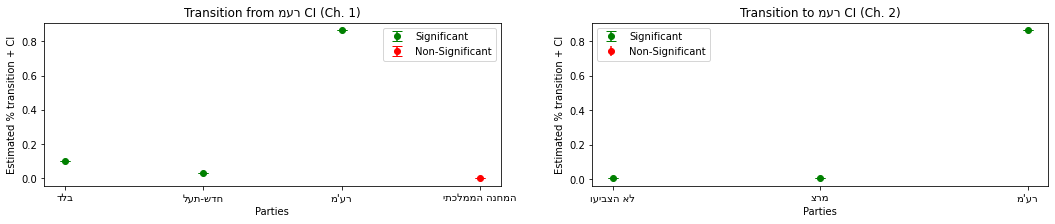

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 3))
plot_error_bar(from_raam_ht_df,ax[0],'Transition from מער CI (Ch. 1)')
plot_error_bar(to_raam_ht_df,ax[1],'Transition to מער CI (Ch. 2)')

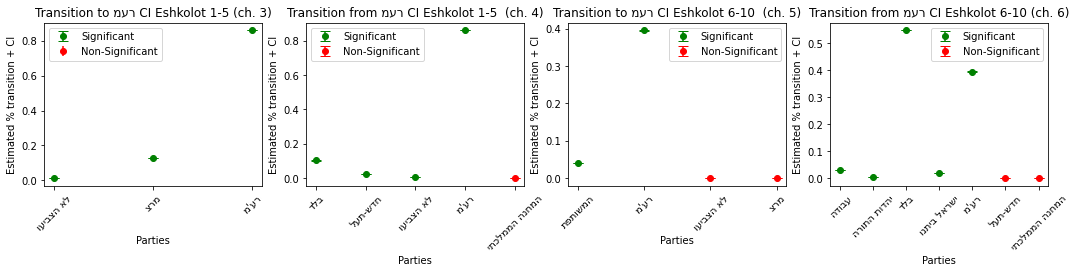

In [ ]:
to_raam_ht_df_low,from_raam_ht_df_low = hypothesis_test_including_bs(df_merged_low,m_hat_df_low)
to_raam_ht_df_high,from_raam_ht_df_high = hypothesis_test_including_bs(df_merged_high,m_hat_df_high)
fig, ax = plt.subplots(1, 4, figsize=(18, 3))
plot_error_bar(to_raam_ht_df_low,ax[0],'Transition to מער CI Eshkolot 1-5 (ch. 3)',True)
plot_error_bar(from_raam_ht_df_low,ax[1],'Transition from מער CI Eshkolot 1-5  (ch. 4)',True)
plot_error_bar(to_raam_ht_df_high,ax[2],'Transition to מער CI Eshkolot 6-10  (ch. 5)',True)
plot_error_bar(from_raam_ht_df_high,ax[3],'Transition from מער CI Eshkolot 6-10 (ch. 6)',True)

In [ ]:
def mse_train_test(na,nb,method=apply_nnls):
  X_train, X_test, y_train, y_test = train_test_split(na, nb, test_size=0.2, random_state=0)
  m_hat_train = method(X_train,y_train)
  predicted_trian = np.dot(X_train, m_hat_train)
  mse_train = ((predicted_trian - y_train) ** 2).mean()
  predicted_test = np.dot(X_test, m_hat_train)
  mse_test = ((predicted_test - y_test) ** 2).mean()
  return mse_train,mse_test

In [ ]:
na,nb = separate_df_to_na_nb(df_merged_ballots,16)
mse_nnls_train, mse_nnls_test = mse_train_test(na,nb,apply_nnls)
mse_ols_train, mse_ols_test = mse_train_test(na,nb,apply_ols)

mse_train_test_df = pd.DataFrame({'mse nnls train':mse_nnls_train,'mse nnls test':mse_nnls_test,
                               'mse ols train':mse_ols_train,'mse ols test':mse_ols_test})
mse_train_test_df = mse_train_test_df.sort_values(by='mse nnls train', ascending=False)

In [ ]:
mse_train_low, mse_test_low = mse_train_test(na_low,nb_low,apply_nnls)
mse_train_high, mse_test_high = mse_train_test(na_high,nb_high,apply_nnls)

mse_train_test_eshkolot_df = pd.DataFrame({'mse low train':mse_train_low,'mse low test':mse_test_low,
                               'mse high train':mse_train_high,'mse high test':mse_test_high})
mse_train_test_eshkolot_df = mse_train_test_eshkolot_df.sort_values(by='mse low train', ascending=False)

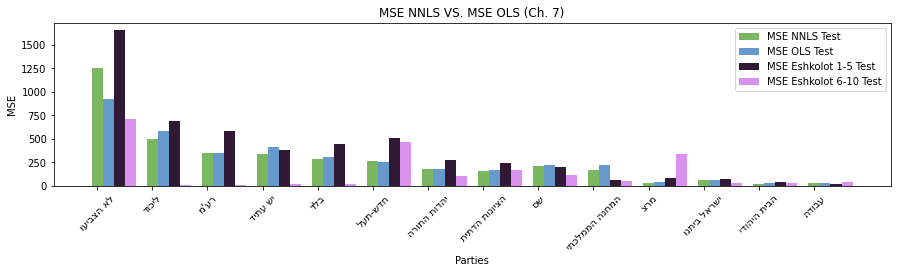

In [ ]:
#fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.figure(figsize=(15, 3))

X = mse_train_test_df.index
X_axis = np.arange(len(X))
mse_train_test_df.index = list(map(lambda st: str.replace(st, "_2022", ""), mse_train_test_df.index))
xticklabels = [parties_letters_to_name_dict_2022[party][::-1] for party in mse_train_test_df.index]

#ax[0].bar(X_axis, mse_train_test_df['mse nnls train'], 0.2, label='MSE NNLS Train',color = '#006B3C')
plt.bar(X_axis, mse_train_test_df['mse nnls test'], 0.2, label='MSE NNLS Test',color = '#7BB661') 
#ax[0].bar(X_axis+0.5, mse_train_test_df['mse ols train'], 0.2, label='MSE OLS Train',color = '#0018A8')
plt.bar(X_axis+0.2, mse_train_test_df['mse ols test'], 0.2, label='MSE OLS Test',color = '#6699CC')
plt.xlabel("Parties")
plt.ylabel("MSE")
plt.title("MSE NNLS VS. MSE OLS (Ch. 7)")
#plt.set_xticks(X_axis)
plt.xticks(X_axis,xticklabels, rotation=45)

#ax[1].bar(X_axis, mse_train_test_eshkolot_df['mse low train'], 0.2, label='MSE Eshkolot 1-5 Train',color = '#9F2B68')
plt.bar(X_axis+0.4, mse_train_test_eshkolot_df['mse low test'], 0.2, label='MSE Eshkolot 1-5 Test',color = '#301934') 
#ax[1].bar(X_axis+0.5, mse_train_test_eshkolot_df['mse high train'], 0.2, label='MSE Eshkolot 6-10 Train',color = '#301934')
plt.bar(X_axis+0.6, mse_train_test_eshkolot_df['mse high test'], 0.2, label='MSE Eshkolot 6-10 Test',color = '#D891EF') 
# ax[1].set_xlabel("Parties")
# ax[1].set_ylabel("MSE")
# ax[1].set_title("MSE Eshkolot 1-5 VS. MSE Eshkolot 6-10 (Ch. 8)")
# ax[1].legend()
# ax[1].set_xticks(X_axis)
# ax[1].set_xticklabels(xticklabels, rotation=45)
plt.legend()

for i, v in enumerate(mse_train_test_df['mse nnls train']):
    plt.annotate(str(''), (i, v), xytext=(0, 10), textcoords='offset points', ha='center')

The hypotheses were defined as follows:
$\bf~H_{0}:\hat{M}_{ij}=0,\hat{M}_{Raam,Raam}=1$; $\bf~H_{1}:\hat{M}_{ij}>0,\hat{M}_{Raam,Raam}<1$; $\bf~\forall i,j\in\left\{ i,j:i\text{ is Raam or j is Raam},i\not=j\right\}$

The hypotheses tests were done by applying normal approximation on each of the estimated transitions $\bf~(\hat{M}_{ij})$, and test whether 1 is within רע״מ CI (as 1 means all רע"מs 2021 voters transitioned to רע״מ at the 2022 elections) and whether
0 value collides with the CI for parties (meaning no transitions between other parties to רע״מ).

The variance was calculated using bootstrap method, due to using NNLS method, which doesnt generate variance. Since there is more than one hypothesis (hypothesis for each relevant $\hat{M}_{ij})$), we used Bonferroni correction for multiple hypotheses, such that the overall statistical error (type 1) would be 1% (confidence level of 99%).

We didnt mentioned hypotheses with estimated variance 0, since it is not possible to perform hypotheses tests.

We splitted the datasets to train (80%) and test (20%) in order to generate unbiased estimator for the error. The MSE was estimated both for NNLS and OLS in order to measure which model gives better predictions. 
It known that the MSE of OLS should be the lowest for unbiased estimators, but after applying the contrains, the OLS estimtors changes (due to the applied constrains) and cannot be considered as OLS any more. 

####Section I
Ensuring the integrity of the electoral process is crucial for maintaining public trust in the results. To this end, we would like to explore and examine any potential instances of suspicious voting patterns with regards to support for the party "Ra'am".

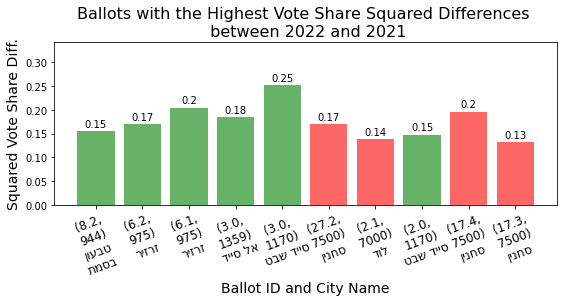

In [ ]:
#Rename Parties
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה"
     , 'ט'  : "הציונות הדתית",'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
parties_dict_2022 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "הבית היהודי", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "המחנה הממלכתי", 'שס'  : "שס", 'ום':'חדש-תעל','ד':'בלד'}


df_ballots_2021_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202021.csv', encoding = 'iso-8859-8', index_col="ברזל")
df_ballots_2021 = df_ballots_2021_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
df_ballots_2021 = df_ballots_2021[df_ballots_2021['שם ישוב']!='מעטפות חיצוניות']  # exclude מעטפות חיצוניות
df_ballots_2021.rename(columns=parties_dict_2021, inplace=True)


df_ballots_2022_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202022.csv',  encoding = 'utf8', index_col="ברזל")
df_ballots_2022 = df_ballots_2022_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
df_ballots_2022 = df_ballots_2022[df_ballots_2022['שם ישוב']!='מעטפות חיצוניות']
df_ballots_2022.rename(columns=parties_dict_2022, inplace=True)


cols = ["רעם", "שם ישוב", 'פסולים','קלפי', 'בזב', 'כשרים','סמל ישוב']

df_ballots_2021 = df_ballots_2021[cols].reset_index()
df_ballots_2022 = df_ballots_2022[cols].reset_index()

ballot_match = df_ballots_2021.set_index(['קלפי', 'סמל ישוב']).join(df_ballots_2022.set_index(['קלפי', 'סמל ישוב']), lsuffix = '-2021').dropna()

# pull the relevant data out of the joined df
df_ballots_2022 = ballot_match[ballot_match.columns[6:]]
df_ballots_2021 = ballot_match[ballot_match.columns[0:6]]
df_ballots_2021.columns = df_ballots_2022.columns

# calculate Ra'am's freq. in each election
df_ballots_2022["freq_2022"] = df_ballots_2022["רעם"] / df_ballots_2022["כשרים"]
df_ballots_2021["freq_2021"] = df_ballots_2021["רעם"] / df_ballots_2021["כשרים"]

df_ballots_2022["freq_2021"] = df_ballots_2021["freq_2021"]  # add freq from prev dataset
df_ballots_2022["diff"] = ((df_ballots_2021["freq_2021"]-df_ballots_2022["freq_2022"])**2)
df_ballots_2022["sign"] = np.where(df_ballots_2022["freq_2022"]-df_ballots_2022["freq_2021"] < 0, -1, 1)

df_ballots_2022.sort_values(by=['diff'], ascending=False, inplace=True)
df_ballots_2022

top_10_diff_ballots = df_ballots_2022.head(10)

# plot the top 10 ballots in terms of change

# create a label column consisting of the ballot number and the city name
top_10_diff_ballots.loc[:,"label"] = top_10_diff_ballots.index.map(str) + " " + top_10_diff_ballots["שם ישוב"].apply(lambda x: x[::-1])
top_10_diff_ballots = top_10_diff_ballots.sort_values(by="label", ascending=False)

labels = top_10_diff_ballots["label"]

labels = ['\n'.join(wrap(l, 8)) for l in labels]

heights = top_10_diff_ballots["diff"]
heights = heights.astype(float)
colors = top_10_diff_ballots["sign"].map({-1: "red", 1: "green"})

plt.figure(figsize=(9,3))
plt.bar(labels, heights, color=colors, alpha=0.6)

# Add text above each bar
for i, height in enumerate(heights):
  plt.text(i, height+0.005, f"{round(height, 2)}", ha='center', va='bottom')

plt.title("Ballots with the Highest Vote Share Squared Differences \n between 2022 and 2021", fontsize=16)
plt.xlabel("Ballot ID and City Name", fontsize=14)
plt.ylabel("Squared Vote Share Diff.", fontsize=14)
plt.ylim(top=plt.ylim()[1]*1.3)
plt.xticks(rotation=20, fontsize=12)
plt.show()

The above plot presents the direction of the party's squared vote share difference between the two election cycles, as depicted by the color-coding. Green represents a vote gain, while red represents a vote loss.

Upon examination of the plot, it can be observed that the data aligns with previous analysis (mainly, our findings throughout sectiond D). Specifically, in the city of Sachnin, a significant decrease in votes for the party is reflected in the high difference in vote shares. Similarly, the city of Al-Sayyid, a Bedouin village in the Negev, demonstrates an increase in support for the party between the election cycles.

Please note that sadly, we are unable to compare this sort of data to Ra'am's competing Arab parties due to changes in these parties between the election cycles, which would result in inaccurate results if we were to interpolate the vote counts ("Ha-meshutefet" was split into "Hadash-Ta'al" and "Balad", for instance). Still, this method did not seem to highlight any notable changes that would raise suspicion.

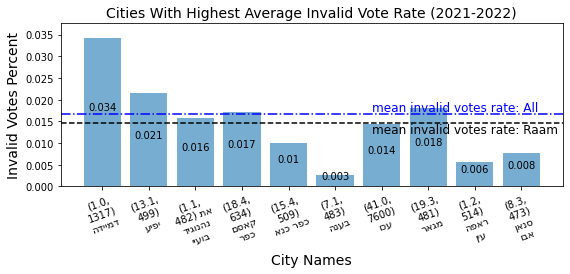

In [ ]:
# only select ballots in which the support of רעמ was significant: above 0.25 of the kosher votes casted
ballot_2021_filtered = df_ballots_2021[df_ballots_2021['רעם']/df_ballots_2021['כשרים'] > 0.25]
ballot_2022_filtered = df_ballots_2022[df_ballots_2022['רעם']/df_ballots_2022['כשרים'] > 0.25]

# calculating the percentage of invalid votes
ballot_2021_filtered["invalid_percent"] = ballot_2021_filtered["פסולים"]/ballot_2021_filtered["בזב"]
ballot_2022_filtered["invalid_percent"] = ballot_2022_filtered["פסולים"]/ballot_2022_filtered["בזב"]

psulim = (ballot_2021_filtered["invalid_percent"] + ballot_2022_filtered["invalid_percent"]) / 2 
top_10_psulim = psulim.nlargest(10).index # drop inf and find largest
top_10_rows = ballot_2022_filtered.loc[top_10_psulim,:]

top_13 = ['הליכוד', 'יש עתיד', 'הציונות הדתית', 'המחנה הממלכתי', 'שס',
          'יהדות התורה', 'ישראל ביתנו', 'רעם', 'חדש-תעל', 'עבודה', 'מרצ', 'בלד',
           'הבית היהודי']

all_data_2021_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202021.csv', encoding = 'iso-8859-8', index_col="ברזל")
all_data_2021 = all_data_2021_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
all_data_2021 = all_data_2021[all_data_2021['שם ישוב']!='מעטפות חיצוניות']  # exclude מעטפות חיצוניות
all_data_2021.rename(columns=parties_dict_2021, inplace=True)


all_data_2022_raw = pd.read_csv('https://raw.githubusercontent.com/zventurero/lab_final/main/votes%20per%20ballot%202022.csv',  encoding = 'utf8', index_col="ברזל")
all_data_2022 = all_data_2022_raw.drop('סמל ועדה', axis=1)  # drop the new column that was added in Sep 2019
all_data_2022 = all_data_2022[all_data_2022['שם ישוב']!='מעטפות חיצוניות']
all_data_2022.rename(columns=parties_dict_2022, inplace=True)

top_parties_mean_psulim_rate = dict()
for party in top_13:
    try:
      # only select ballots in which the support of רעמ was significant- 
      # above 0.25 of the kosher votes casted
      all_data_2021_filtered = all_data_2021[all_data_2021[party]/all_data_2021['כשרים'] > 0.25]
      all_data_2022_filtered = all_data_2022[all_data_2022[party]/all_data_2022['כשרים'] > 0.25]

      all_data_2021_filtered["invalid_percent"] = all_data_2021_filtered['פסולים']/all_data_2021_filtered['בזב']
      all_data_2022_filtered["invalid_percent"] = all_data_2022_filtered['פסולים']/all_data_2022_filtered['בזב']

      psulim = (all_data_2021_filtered["invalid_percent"] + all_data_2021_filtered["invalid_percent"]) / 2
      party_top_10 = psulim.nlargest(10)  # drop inf and find largest
      top_parties_mean_psulim_rate[party] = party_top_10.mean()

    except KeyError:  # ignore parties do not exist in both elections
        continue

# pull the relevant info regarding the top cities in terms of avg. psulim rate
#indices_list = [i for i in top_10_psulim]
#city_names = [ballot_2022_filtered.at[i, "שם ישוב"] for i in indices_list]
#rev_city_names = [name[::-1] for name in city_names]
#city_psulim = [ballot_2022_filtered.at[i, "invalid_percent"] for i in indices_list]

# create a label column consisting of the ballot number and the city name
labels = top_10_rows.index.map(str) + " " + top_10_rows["שם ישוב"].apply(lambda x: x[::-1])
labels = ['\n'.join(wrap(l, 7)) for l in labels]

plt.figure(figsize=(9,3))
width = 0.3
plt.bar(labels, top_10_rows["invalid_percent"], alpha=0.6)

# Add text above each bar
for i, height in enumerate(top_10_rows["invalid_percent"]):
  plt.text(i, height/2, str(round(height, 3)), ha='center', va='bottom')

mean_psulim = sum(top_10_rows["invalid_percent"]) / len(top_10_rows["invalid_percent"])
plt.axhline(y=mean_psulim, color='black', linestyle='--')
plt.text(5.8, mean_psulim-0.0015, 'mean invalid votes rate: Raam', rotation=0, va='center', fontsize=12)

mean_psulim_all = sum(top_parties_mean_psulim_rate.values())/len(top_parties_mean_psulim_rate)
plt.axhline(y=mean_psulim_all, color='blue', linestyle='-.')
plt.text(5.8, mean_psulim_all+0.0015, 'mean invalid votes rate: All', rotation=0, va='center', color='blue', fontsize=12)

plt.title("Cities With Highest Average Invalid Vote Rate (2021-2022)", fontsize=14)
plt.xticks(rotation=20)
plt.ylabel('Invalid Votes Percent', fontsize=14)
plt.ylim(top=plt.ylim()[1]*1.05)
plt.xlabel('City Names', fontsize=14)
plt.show()

The above plot compares the mean rate of invalid votes for "Ra'am" party with the rest of leading parties in the election years 2022 and 2021. From the plot, it can be observed that the mean rate of invalid votes for "Ra'am" is lower than that of other leading parties. However, there are some cities such as "Dmeide" and "Yafa" (both are Bedouin villages, in the Galilee), where the rate of invalid votes is quite high, and exceeds the mean values presented. 

It's important to note that the bureaucracy surrounding vote counts and what constitutes an invalid vote is complex and there may be various reasons for the high rate of spoiled votes in these cities. Having said that, it could be valuable to investigate the reasons behind the high rates of invalid votes in the specified ballots. This could potentially indicate malicious intent, and it is fortunate that it was detected. However, it is also possible that this is simply a result of inadequate education on the proper voting procedures.





We used two ways in an attempt to look for suspicious ballots:

1.   Identifying ballots where support levels for the party in 2022 deviate significantly from the results of the same ballots in 2021. This includes ballots where the party experienced sudden surges in support or significant losses in support, which may indicate suspicious activity if no plausible explanation is found. This information will be compared to the data of the leading parties in each election cycle.
2.   Identifying ballots where the rate of invalid votes (also known as "spoiled" votes) were the highest among the ballots where the party received a significant amount of support (this will allow us to infer, or assume, that a portion of the party's votes were likely "spoiled").
Specifically, we will examine ballots where the support for "Ra'am" was significant (at least 25% of the votes in the ballot) in both election cycles, compute the average between the two years, and then analyze the top ten ballots with the highest percentage of invalid votes among all eligible voters ("bzb") in that ballot.

It is worth noting that we have decided not to manipulate the votes between the election cycles or apply any logic to how the votes of a non-existing party in one election year are split among the parties in the other election year. This is due to the fact that this method will always be inherently inaccurate and the value it provides is too minimal to justify its use.